# Partial GT on the 9-state Network

The model network comprises 994 nodes and 4320 bidirectional edges, and
can roughly be divided into 9 competing macrostates. There are also high
energy nodes and a couple of small features, so the network is a
realistic and challenging example. The node degree distribution is
fitted to a Poisson function and the energy barrier heights have some
spread arising from the underlying potential + numerical noise. This is
realistic and will allow us to look at the effect of partial GT
heuristics based on node degree, waiting time, and energy.

Between T=10 and T=0.1 the network exhibits rate constants in the range
10^{-3} to 10^{-30}, with multi-state and multi-pathway kinetics. The
metastability at ambient temperatures (eg T=1, where the MFPT is around
6.5 x 10^{12}) renders standard kMC useless, but kPS does just fine. I
have also uploaded some kPS results at T=1 including the FPT
distribution, transition path probability densities and committor
probabilities.

In [1]:
#library code
import lib.ktn_io as kio
import lib.gt_tools as gt
import lib.partialGT as pgt
import lib.conversion as convert
from ktn.ktn_analysis import *
#other imports
import numpy as np
from io import StringIO
import time,os, importlib
from tqdm import tqdm
np.set_printoptions(linewidth=160)
from scipy.sparse import save_npz,load_npz, diags, eye, csr_matrix,bmat
from scipy.sparse.linalg import eigs,inv,spsolve
from scipy.sparse.csgraph import connected_components
import scipy as sp
import scipy.linalg as spla
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from pathlib import Path
import seaborn as sns
sns.set()
%matplotlib inline

Using tqdm package for pretty progress bars!


In [2]:
# index_sel = which states in data file are part of largest connected component and hence are included in KTN
# only states where index_sel = True feature in K,D,B etc. i.e. N = index_sel.sum()
# B: braching prob, K = rates, D = total rate per state, u = energy, s = entropy, Emin = min E, 

data_path = Path("KTN_data/9state")
temp = 10.
beta = 1./temp
B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=data_path,beta=beta,Emax=None,Nmax=None,screen=True)
#array of inverse waiting times
D = np.ravel(K.sum(axis=0)) 
#free energy of minima
BF = beta*u-s
#rescaled
BF -= BF.min()
Amin = 585
Bmin = 827

communities = pgt.read_communities(data_path/'communities_bace9.dat', index_sel, screen=True)
for ci in communities:
    if communities[ci][Amin - 1]:
        print(f"Community A: {ci}")
    if communities[ci][Bmin - 1]:
        print(f"Community B: {ci}")

Connected Clusters: 1, 1st 400 states in largest cluster: 1
cc: N: 994->994 (994,) (994,)
Community 0: 112
Community 1: 130
Community 2: 89
Community 3: 147
Community 4: 110
Community 5: 85
Community 6: 186
Community 7: 98
Community 8: 37
Community B: 3
Community A: 7


In [3]:
#re-write min.A/min.B files to be consistent with new BACE communities
ktn_comms = convert.ktn_comms_from_gt_comms(communities)
Aind = 7+1
Bind = 3+1
convert.write_minA_minB(ktn_comms, Aind, Bind, data_path)
# AB regions
AS,BS = kio.load_AB(data_path,index_sel)
print(f'Num in A: {AS.sum()}')
print(f'Num in B: {BS.sum()}')
print(f'Num in I: {index_sel.sum() - AS.sum() - BS.sum()}')

Num in A: 98
Num in B: 147
Num in I: 749


In [4]:
#also write a communities_AB.dat file for kPS simulations
convert.write_AB_communities_from_gt(communities, Aind-1, Bind-1, data_path, suffix='_AB')

## Choosing Nodes to Eliminate

In [13]:
#Attempt to rank nodes based on free energy, escape time, node degree, and see what we get
def rank_nodes_to_eliminate(beta=1.0, rm_type='hybrid', percent_retained=10, 
                            log=False, escape_time_upper_bound=None):
    Nmax = None
    data_path = "KTN_data/9state"
    B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=data_path,beta=beta,Emax=None,Nmax=Nmax,screen=False)
    D = np.ravel(K.sum(axis=0)) #array of size (N,) containing escape rates for each min
    BF = beta*u-s
    BF -= BF.min()
    rho = np.exp(-BF)
    rho /= rho.sum()
    escape_times = 1.0/D
    node_degree = B.indptr[1:] - B.indptr[:-1]
    print(f'Number of nodes with >1 connection: {len(node_degree[node_degree > 1])}')
    AS,BS = kio.load_AB(data_path,index_sel)
    #AS = np.zeros(N, bool)
    #BS = np.zeros(N, bool)
    #AS[Amin-1] = True
    #BS[Bmin-1] = True
    IS = np.zeros(N, bool)
    IS[~(AS+BS)] = True
    print(f'A: {AS.sum()}, B: {BS.sum()}, I: {IS.sum()}')
    
    rm_reg = np.zeros(N,bool)
    #color nodes that we would propose to remove
    if rm_type == 'node_degree':
        rm_reg[node_degree < 2] = True
        rm_reg[(AS+BS)] = False #only remove the intermediate nodes this time

    if rm_type == 'escape_time':
        #remove nodes with the smallest escape times
        #retain nodes in the top percent_retained percentile of escape time
        rm_reg[IS] = escape_times[IS] < np.percentile(escape_times[IS], 100.0 - percent_retained)

    if rm_type == 'free_energy':
        rm_reg[IS] = BF[IS] > np.percentile(BF[IS], percent_retained)
    
    if rm_type == 'peq':
        rm_reg[IS] = rho[IS] < np.percentile(rho[IS], 100.0 - percent_retained)
    
    if rm_type == 'combined':
        rho_local = rho[IS]/rho[IS].sum()
        combo_metric = escape_times[IS] * rho_local
        rm_reg[IS] = combo_metric < np.percentile(combo_metric, 100.0 - percent_retained)
        
    if rm_type == 'hybrid':
        #remove nodes in the top percent_retained percentile of escape time
        time_sel = (escape_times[IS] < np.percentile(escape_times[IS], 100.0 - percent_retained))
        bf_sel = (rho[IS] < np.percentile(rho[IS], 100.0 - percent_retained))
        sel = np.bitwise_and(time_sel, bf_sel)
        #that are also in the lowest percent_retained percentile of free energy
        rm_reg[IS] = sel
    print(f'Percent eliminated: {100*rm_reg.sum()/N}')
    print(rho.min(), rho.max())
    fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(15,4))
    colors = sns.color_palette("Paired")
    #node degree vs escape time
    ax.scatter(node_degree[~rm_reg], escape_times[~rm_reg], color=colors[8], alpha=0.4, label='I')
    ax.scatter(node_degree[AS], escape_times[AS], color=colors[5], alpha=0.8, label='A')
    ax.scatter(node_degree[BS], escape_times[BS], color=colors[1], alpha=0.8, label='B')
    ax.scatter(node_degree[rm_reg], escape_times[rm_reg], color=colors[9], alpha=0.4, label='rm')
    ax.set_xlabel('Node Degree')
    ax.set_ylabel('Escape Time')
    if log:
        ax.set_yscale('log')
    if escape_time_upper_bound is not None:
        ax.set_ylim([-1.0, escape_time_upper_bound])
    ax.legend()
    #free energy vs escape time
    ax1.scatter(rho[~rm_reg], escape_times[~rm_reg], color=colors[8], alpha=0.4, label='I')
    ax1.scatter(rho[AS], escape_times[AS], color=colors[5], alpha=0.8, label='A')
    ax1.scatter(rho[BS], escape_times[BS], color=colors[1], alpha=0.8, label='B')
    ax1.scatter(rho[rm_reg], escape_times[rm_reg], color=colors[9], alpha=0.4, label='rm')
    ax1.set_xlabel('Equilibrium probability')
    ax1.set_xlim([0.0, 0.006])
    ax1.set_ylabel('Escape Time')
    if log:
        ax1.set_yscale('log')
    if escape_time_upper_bound is not None:
        ax.set_ylim([-1.0, escape_time_upper_bound])
    ax1.legend()
    #node degree vs free energy
    ax2.scatter(rho[~rm_reg], node_degree[~rm_reg], color=colors[8], alpha=0.4, label='I')
    ax2.scatter(rho[AS], node_degree[AS], color=colors[5], alpha=0.8, label='A')
    ax2.scatter(rho[BS], node_degree[BS], color=colors[1], alpha=0.8, label='B')
    ax2.scatter(rho[rm_reg], node_degree[rm_reg], color=colors[9], alpha=0.4, label='rm')
    ax2.set_xlabel('Equilibrium probability')
    ax2.set_xlim([0.0, 0.006])
    ax2.set_ylabel('Node Degree')
    ax2.legend()
    plt.show()
    fig.tight_layout()

Number of nodes with >1 connection: 994
A: 1, B: 1, I: 992


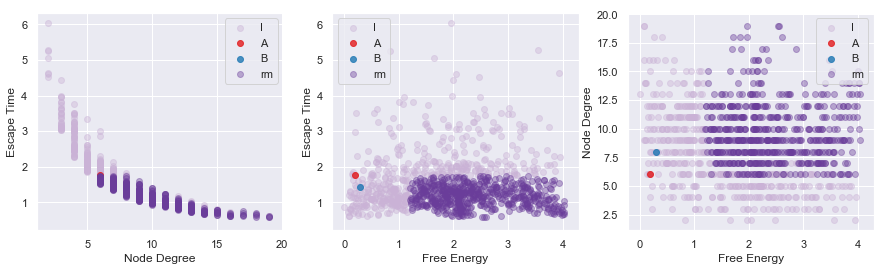

In [23]:
rank_nodes_to_eliminate(beta=1./10., percent_retained=25, rm_type='hybrid')

Number of nodes with >1 connection: 994
A: 1, B: 1, I: 992
Percent eliminated: 51.91146881287727
8.133540756916518e-05 0.004587512830506054


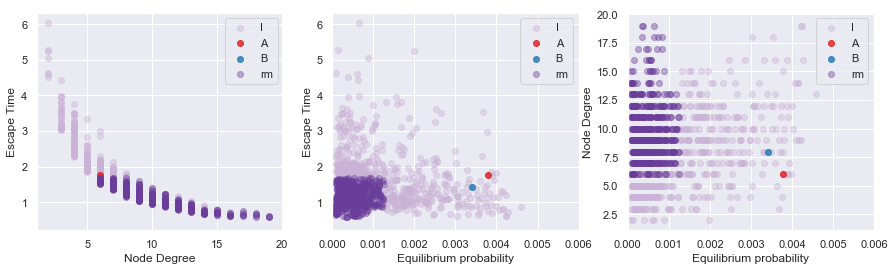

In [15]:
rank_nodes_to_eliminate(beta=1./10., percent_retained=27, rm_type='hybrid')

Number of nodes with >1 connection: 994
A: 1, B: 1, I: 992


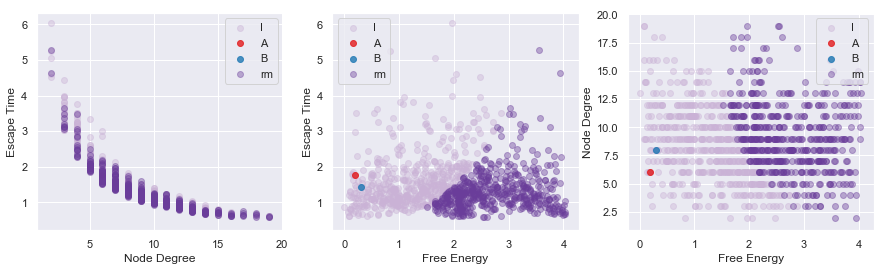

In [31]:
rank_nodes_to_eliminate(beta=1./10., percent_retained=50, rm_type='combined')

Number of nodes with >1 connection: 994
A: 1, B: 1, I: 992
Percent eliminated: 49.899396378269614
8.133540756916518e-05 0.004587512830506054


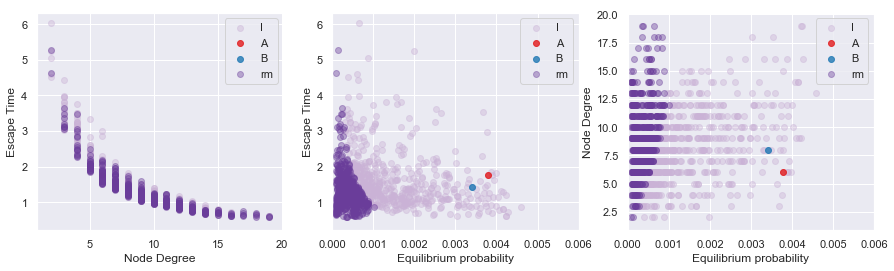

In [16]:
rank_nodes_to_eliminate(beta=1./10., percent_retained=50, rm_type='combined')

Number of nodes with >1 connection: 994
A: 1, B: 1, I: 992


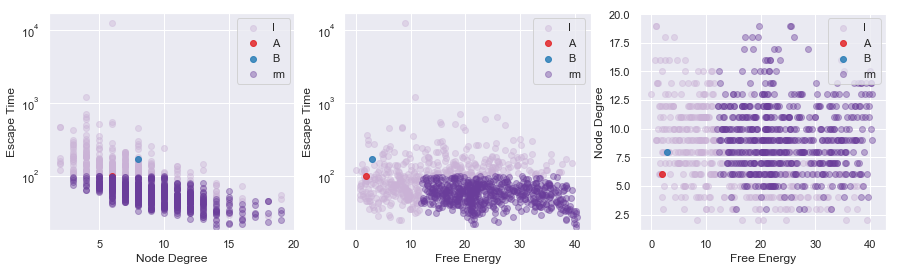

In [24]:
temp = 1.0
rank_nodes_to_eliminate(beta=1./temp, percent_retained=25, log=True)

Number of nodes with >1 connection: 994
A: 1, B: 1, I: 992


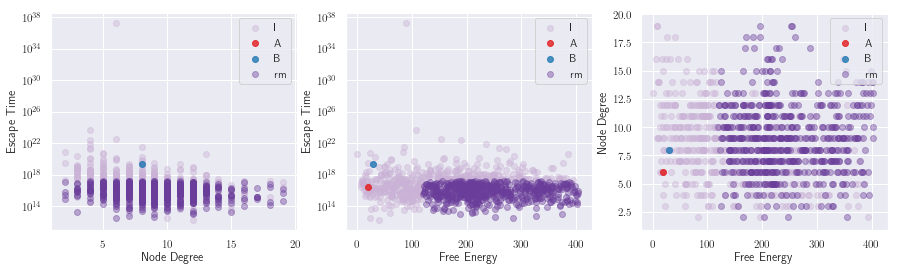

In [19]:
temp = 0.1
rank_nodes_to_eliminate(beta=1./temp, percent_retained=25, log=True)

### Compare hybrid nodes to transition path probabilities and committors

Both of these quantities can be calculated via kPS simulations, but are temperature dependent. So we'd have to re-run simulations at each temperature to use these quantities as heuristics for partial GT. However, it could provide a nice post-processing analysis to compare how partial GT heuristics measure up against these other quantities, which also demonstrate how A-->B dynamics are extremely localized.

In [92]:
data_path = Path("KTN_data/9state")
temp = 1.
beta = 1./temp
B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=data_path,beta=beta,Emax=None,Nmax=None,screen=True)
D = np.ravel(K.sum(axis=0)) 
#escape time
escape_times = 1./D
#free energy of minima
BF = beta*u-s
#rescaled
BF -= BF.min()
#node degree
node_degree = B.indptr[1:] - B.indptr[:-1]
# AB regions
AS,BS = kio.load_AB(data_path,index_sel)
#AS = np.zeros(N, bool)
#BS = np.zeros(N, bool)
#AS[Amin-1] = True
#BS[Bmin-1] = True
IS = np.zeros(N, bool)
IS[~(AS+BS)] = True
print(f'Num in A: {AS.sum()}')
print(f'Num in B: {BS.sum()}')
print(f'Num in I: {IS.sum()}')
#committor AB
committor_AB = np.loadtxt(Path(data_path)/'committor_AB.dat')
committor_BA = np.loadtxt(Path(data_path)/'committor_BA.dat') #1 - committor_AB
tp_densities = np.loadtxt(Path(data_path)/'tp_stats.dat')[:,3]
df = pd.DataFrame(columns=['Id','tpd', 'escape_time'])
df['Id'] = np.arange(1, N+1, 1)
df['tpd'] = tp_densities
df['escape_time'] = escape_times
df.to_csv(Path(data_path)/'tp_densities_waiting_times.csv', index=False)

Connected Clusters: 1, 1st 400 states in largest cluster: 1
cc: N: 994->994 (994,) (994,)
Num in A: 98
Num in B: 147
Num in I: 749


In [93]:
def scatter_committors_tpd(beta = 1.0, rm_type='hybrid', percent_retained=10, 
                            log=False, escape_time_upper_bound=None):
    rm_reg = np.zeros(N,bool)
    #color nodes that we would propose to remove
    if rm_type == 'node_degree':
        rm_reg[node_degree < 2] = True
        rm_reg[(AS+BS)] = False #only remove the intermediate nodes this time

    if rm_type == 'escape_time':
        #remove nodes with the smallest escape times
        #retain nodes in the top percent_retained percentile of escape time
        rm_reg[IS] = escape_times[IS] < np.percentile(escape_times[IS], 100.0 - percent_retained)

    if rm_type == 'free_energy':
        rm_reg[IS] = BF[IS] > np.percentile(BF[IS], percent_retained)

    if rm_type == 'combined':
        rho = np.exp(-BF)
        rho /= rho.sum()
        combo_metric = escape_times * rho
        rm_reg[IS] = combo_metric[IS] < np.percentile(combo_metric[IS], 100.0 - percent_retained)
        
    if rm_type == 'hybrid':
        #remove nodes in the top percent_retained percentile of escape time
        time_sel = (escape_times[IS] < np.percentile(escape_times[IS], 100.0 - percent_retained))
        bf_sel = (BF[IS]>np.percentile(BF[IS],percent_retained))
        sel = np.bitwise_and(time_sel, bf_sel)
        #that are also in the lowest percent_retained percentile of free energy
        rm_reg[IS] = sel
    fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(15,4))
    colors = sns.color_palette("Paired")
    #committor vs tp_density
    ax.scatter(committor_AB[~rm_reg], tp_densities[~rm_reg], color=colors[8], alpha=0.4, label='I')
    ax.scatter(committor_AB[AS], tp_densities[AS], color=colors[5], alpha=0.8, label='A')
    ax.scatter(committor_AB[BS], tp_densities[BS], color=colors[1], alpha=0.8, label='B')
    ax.scatter(committor_AB[rm_reg], tp_densities[rm_reg], color=colors[9], alpha=0.8, label='rm')
    ax.set_xlabel('Comittor AB')
    ax.set_ylabel('Transition path probability density')
    ax.legend()
    #tp_density vs escape time
    ax1.scatter(tp_densities[~rm_reg], escape_times[~rm_reg], color=colors[8], alpha=0.4, label='I')
    #ax1.scatter(tp_densities[AS], escape_times[AS], color=colors[5], alpha=0.8, label='A')
    #ax1.scatter(tp_densities[BS], escape_times[BS], color=colors[1], alpha=0.8, label='B')
    ax1.scatter(tp_densities[rm_reg], escape_times[rm_reg], color=colors[9], alpha=0.8, label='rm')
    ax1.set_xlabel('tp density')
    ax1.set_ylabel('Escape Time')
    if log:
        ax1.set_yscale('log')
    if escape_time_upper_bound is not None:
        ax.set_ylim([-1.0, escape_time_upper_bound])
    ax1.legend()
    #tp_density vs free energy
    ax2.scatter(BF[~rm_reg], tp_densities[~rm_reg], color=colors[8], alpha=0.4, label='I')
    #ax2.scatter(BF[AS], tp_densities[AS], color=colors[5], alpha=0.8, label='A')
    #ax2.scatter(BF[BS], tp_densities[BS], color=colors[1], alpha=0.8, label='B')
    ax2.scatter(BF[rm_reg], tp_densities[rm_reg], color=colors[9], alpha=0.8, label='rm')
    ax2.set_xlabel('Free Energy')
    ax2.set_ylabel('tp density')
    ax2.legend()
    plt.show()
    fig.tight_layout()

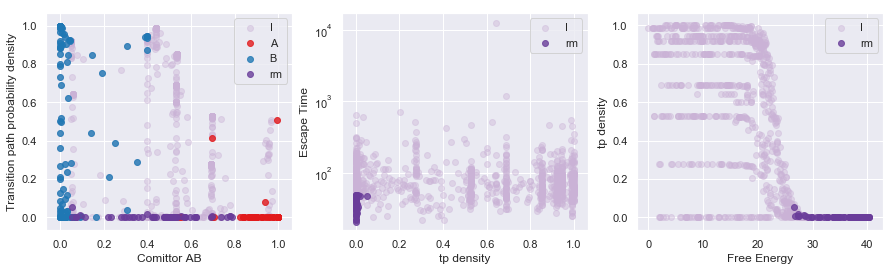

In [94]:
scatter_committors_tpd(percent_retained=75, log=True)

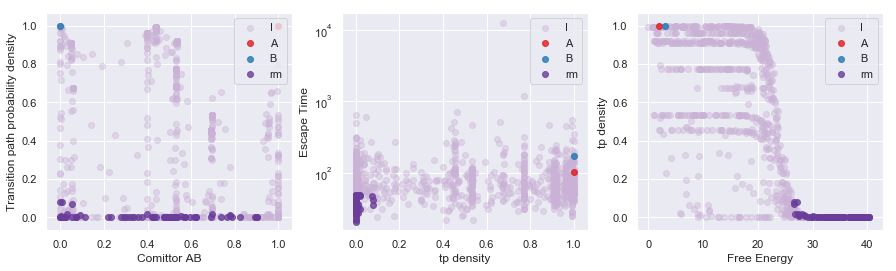

In [22]:
scatter_committors_tpd(percent_retained=75, log=True)

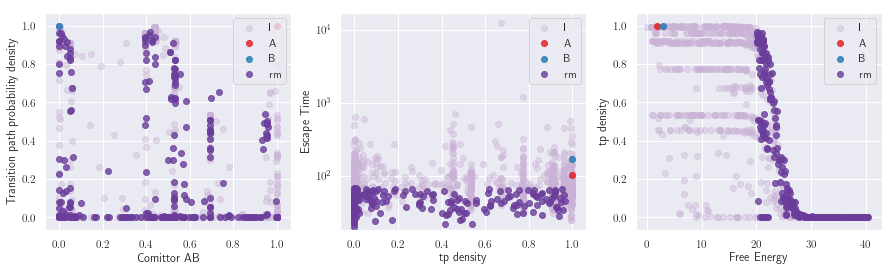

In [19]:
scatter_committors_tpd(percent_retained=50, log=True)

It does appear that the high-free-energy, short-lived states removed by the hybrid approach happen to have a small transition path probability density, which makes sense. It's also interesting to note that there's an exponential relationship between tpp density and free energy. So if we remove more than 25% of the nodes by free energy/escape time, we'll be removing nodes with a high tpp density.

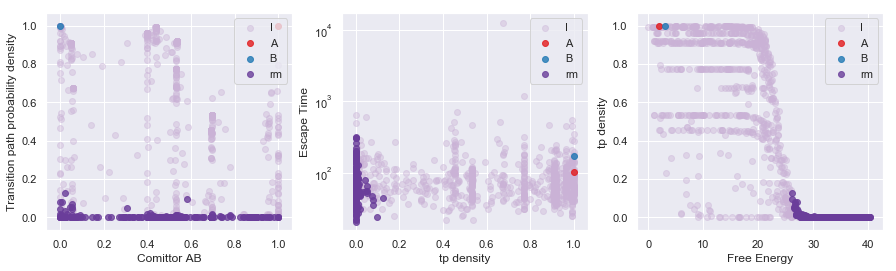

In [35]:
scatter_committors_tpd(percent_retained=75, rm_type='combined', log=True)

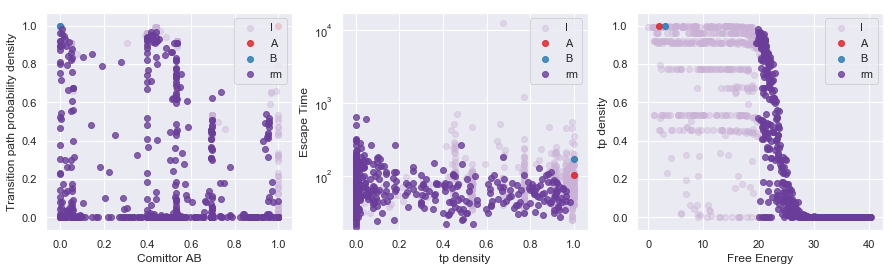

In [36]:
scatter_committors_tpd(percent_retained=50, rm_type='combined', log=True)

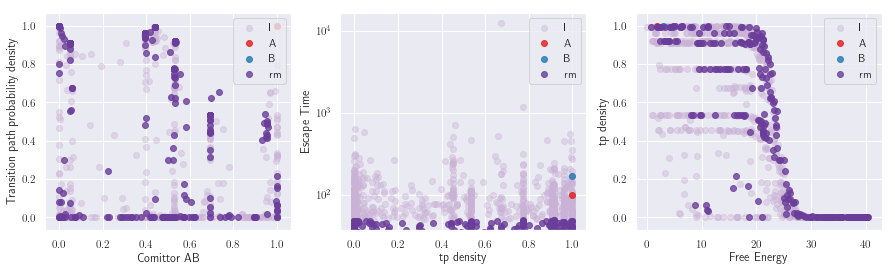

In [17]:
scatter_committors_tpd(percent_retained=75, rm_type = 'escape_time', log=True)

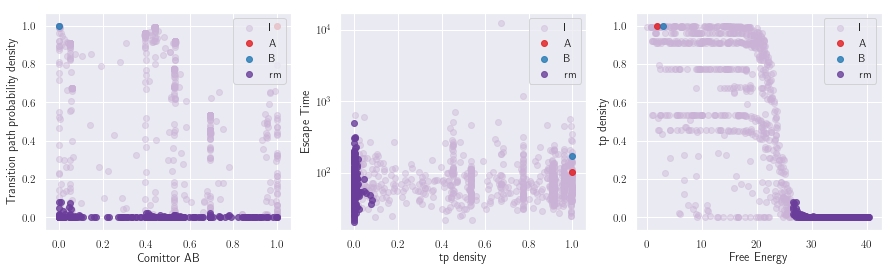

In [18]:
scatter_committors_tpd(percent_retained=75, rm_type = 'free_energy', log=True)

## Partial GT for A<->B first passage time distribution

In [2]:
def plot_AB_waiting_time(beta, data_path='KTN_data/9state', rm_type='hybrid', percent_retained=10, **kwargs):
    """ Plot two panels, A->B first passage time in full and reduced networks,
    and B->A first passage time in full and reduced networks. Reduce networks
    with three different heuristics (escape_time, free_energy, hybrid).
    """
    beta, tau, gttau, pt, gtpt = pgt.prune_intermediate_nodes(beta, data_path, rm_type=rm_type,  
                            percent_retained=percent_retained, dopdf=True, **kwargs)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    colors = sns.color_palette("bright", 10)
    names = ["A", "B"]
    for j in range(2):
        ax[j].set_title(r"%s$\to$%s (T=%2.2g)" % (names[j], names[1-j],1.0/beta))
        #full
        ax[j].plot(pt[2*j]/tau[2*j],pt[1+2*j],'-', color=colors[0], lw=2,
            label=r"Full $p_\mathcal{%s\to{%s}}(t)$" % (names[j],names[1-j]))
        #reduced
        ax[j].plot(gtpt[2*j]/gttau[2*j],gtpt[1+2*j],'-.',color=colors[1], lw=2,
            label=r"$p^{GT}_\mathcal{%s\to{%s}}(t)$, %s" % (names[j],names[1-j], rm_type))
        ax[j].set_xlabel(r"$t/\langle t \rangle$")
        if j==0:
            ax[j].set_ylabel(r"$\langle t \rangle p(t/\langle t \rangle)$")
        #if j==1:
        ax[j].legend()
        ax[j].set_xscale('log')
        ax[j].set_yscale('log')
        #ax[j].set_xlim(0.001,1000.)
        #ax[j].set_ylim(pt[1+2*j].min()/10.0,10.0)
    fig.tight_layout()

## T = 0.1

A: 98, B: 147, I: 749


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:117: RuntimeWarning: overflow encountered in exp
  pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:117: RuntimeWarning: overflow encountered in multiply
  pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:134: RuntimeWarning: overflow encountered in exp
  pt[3] = (v*w*nu)@np.exp(-np.outer(nu,pt[2]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:134: RuntimeWarning: invalid value encountered in matmul
  pt[3] = (v*w*nu)@np.exp(-np.outer(nu,pt[2]))*(v*w/nu).sum()


Nodes to eliminate: 609/994, percent retained: 18.69158878504673
in A: 0, in B: 0, in I: 609


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:117: RuntimeWarning: overflow encountered in exp
  pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:117: RuntimeWarning: overflow encountered in multiply
  pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:134: RuntimeWarning: overflow encountered in exp
  pt[3] = (v*w*nu)@np.exp(-np.outer(nu,pt[2]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:134: RuntimeWarning: invalid value encountered in matmul
  pt[3] = (v*w*nu)@np.exp(-np.outer(nu,pt[2]))*(v*w/nu).sum()
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/ma/core.py:6759: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


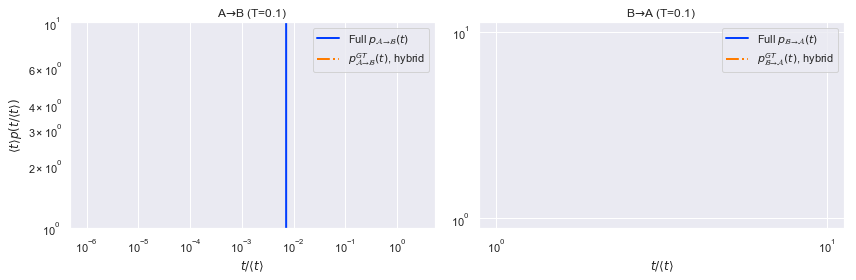

In [8]:
plot_AB_waiting_time(beta=1.0/0.1, rm_type='hybrid', percent_retained=10)

## T=1.0

A: 98, B: 147, I: 749
Nodes to eliminate: 676/994, percent retained: 9.746328437917223
in A: 0, in B: 0, in I: 676


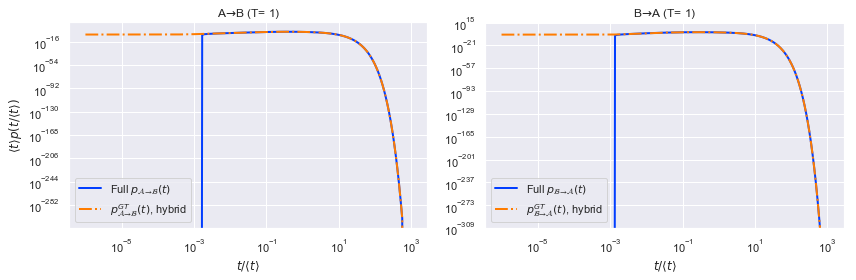

In [4]:
plot_AB_waiting_time(beta=1.0, rm_type='hybrid', percent_retained=5)

A: 98, B: 147, I: 749
Nodes to eliminate: 674/994, percent retained: 10.013351134846461
in A: 0, in B: 0, in I: 674


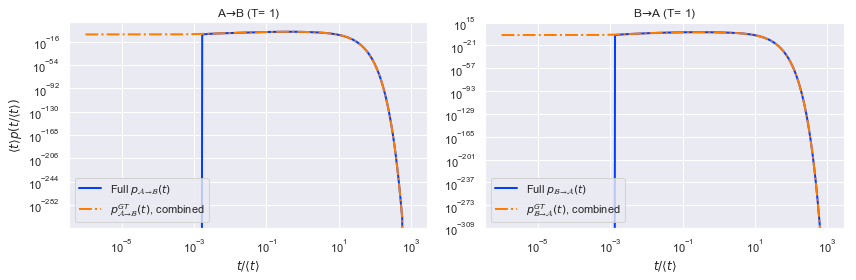

In [5]:
plot_AB_waiting_time(beta=1.0, rm_type='combined', percent_retained=10)

A: 98, B: 147, I: 749
Nodes to eliminate: 674/994, percent retained: 10.013351134846461
in A: 0, in B: 0, in I: 674


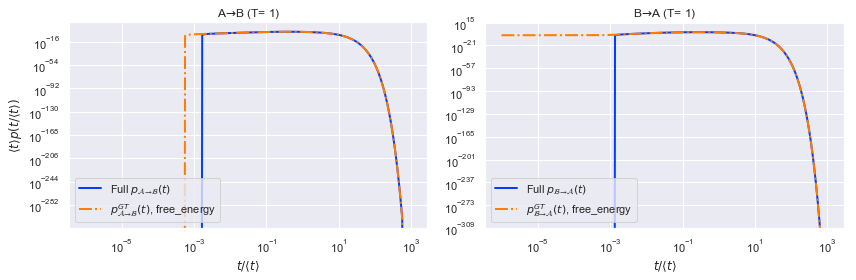

In [6]:
plot_AB_waiting_time(beta=1.0, rm_type='free_energy', percent_retained=10)

A: 98, B: 147, I: 749
Nodes to eliminate: 674/994, percent retained: 10.013351134846461
in A: 0, in B: 0, in I: 674


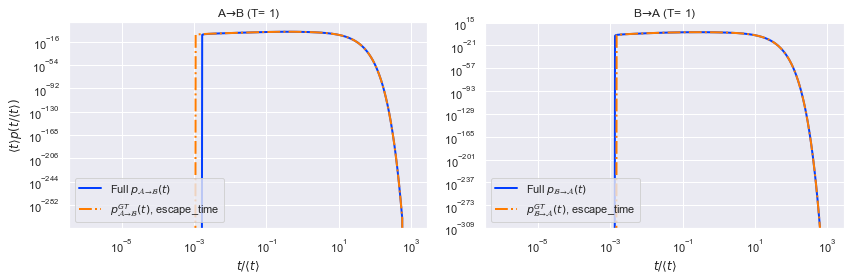

In [7]:
plot_AB_waiting_time(beta=1.0, rm_type='escape_time', percent_retained=10)

Eigendecomposition fails on the full network at T=1.0. In all three GT-reduced networks, the eigendecomposition is possible in the reduced networks in the B->A direction. However, in A->B direction, removing by `escape time` or by `free energy` makes eigendecomposition fail in the reduced network. The `hybrid` and `combined` approaches succeed in producing a well-condition reduced-rank matrix that is amenable to eigendecomposition.

## T = 10

A: 98, B: 147, I: 749
Nodes to eliminate: 674/994, percent retained: 10.013351134846461
in A: 0, in B: 0, in I: 674


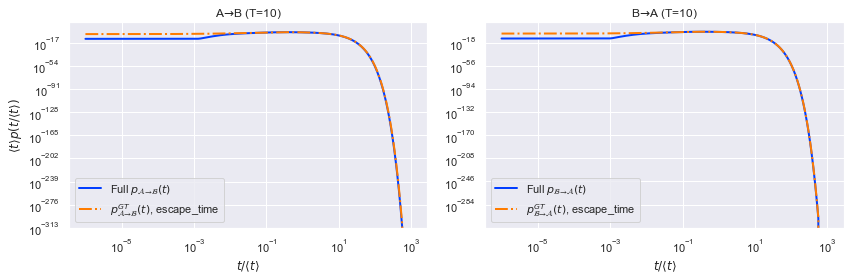

In [10]:
plot_AB_waiting_time(beta=1.0/10., rm_type='escape_time', percent_retained=10)

A: 98, B: 147, I: 749
Nodes to eliminate: 674/994, percent retained: 10.013351134846461
in A: 0, in B: 0, in I: 674


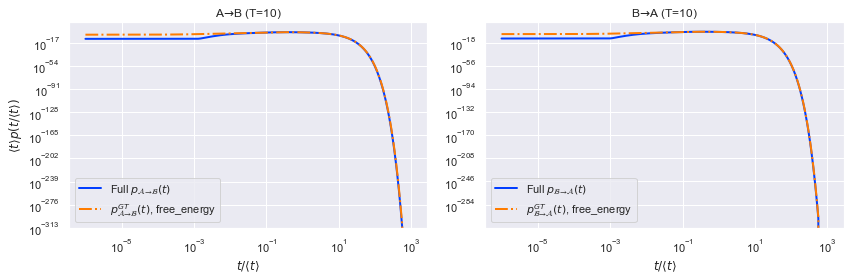

In [11]:
plot_AB_waiting_time(beta=1.0/10., rm_type='free_energy', percent_retained=10)

A: 98, B: 147, I: 749
Nodes to eliminate: 674/994, percent retained: 10.013351134846461
in A: 0, in B: 0, in I: 674


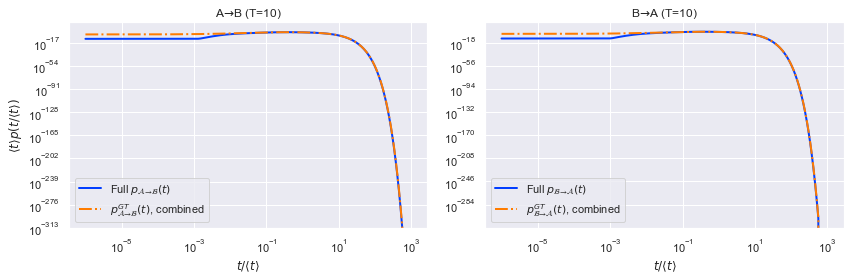

In [12]:
plot_AB_waiting_time(beta=1.0/10., rm_type='combined', percent_retained=10)

A: 98, B: 147, I: 749
Nodes to eliminate: 674/994, percent retained: 10.013351134846461
in A: 0, in B: 0, in I: 674


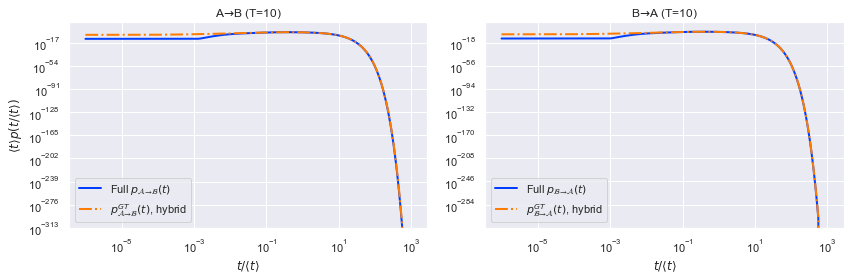

In [13]:
plot_AB_waiting_time(beta=1.0/10., rm_type='hybrid', percent_retained=5)

## T=20

A: 98, B: 147, I: 749
Nodes to eliminate: 674/994, percent retained: 10.013351134846461
in A: 0, in B: 0, in I: 674


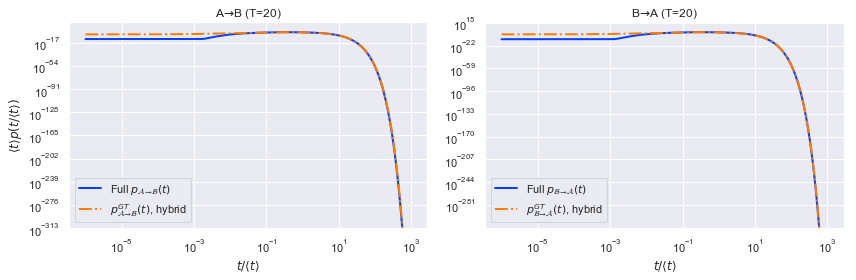

In [14]:
plot_AB_waiting_time(beta=1.0/20., rm_type='hybrid', percent_retained=5)

## Compute mean and variance of FPT distribution

In [15]:
def plot_AB_fpt_moments_vs_temperature(betas, rm_type='hybrid', percent_retained=10, data_path='KTN_data/9state/'):
    data = np.zeros((9, len(betas)))
    for i, beta in enumerate(betas):
        data[0,i], data[1:5,i], data[5:9,i] = pgt.prune_intermediate_nodes(beta, dopdf=False, rm_type=rm_type,
                                                        percent_retained=percent_retained, data_path=data_path, screen=False)
    fig, ax = plt.subplots(1,2,figsize=(10,4),dpi=120,sharey=True)
    for j in range(2):
        names=['A','B']
        size = [98, 53]
        ax[j].set_title(r"%s$\to$%s (from %d$\to$%d states)" % (names[j],names[1-j],size[j],size[1-j]))
        #full
        ax[j].plot(data[0,:],data[1+2*j,:],'C0-',lw=3,label=r"$\langle\tau\rangle_\mathcal{%s\to{%s}}$" % (names[j],names[1-j]))
        ax[j].plot(data[0,:],np.sqrt(data[2+2*j,:]-data[1+2*j,:]**2),'C2-.',lw=3,label=r"$\sigma_\mathcal{%s\to{%s}}$" % (names[j],names[1-j]))
        #reduced
        ax[j].plot(data[0,:],data[5+2*j,],'C1--',lw=3,label=r"$\langle\tau\rangle_\mathcal{%s\to{%s}}$ (GT)" % (names[j],names[1-j]))
        ax[j].plot(data[0,:],np.sqrt(data[6+2*j,:]-data[5+2*j,:]**2),'C3--',lw=3,label=r"$\sigma_\mathcal{%s\to{%s}}$ (GT)" % (names[j],names[1-j]))
        ax[j].set_xlabel(r"$1/T$")
        if j==0:
            ax[j].set_ylabel("Time")
        ax[j].legend()
        ax[j].set_yscale("log")
    fig.tight_layout()
        

/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:134: RuntimeWarning: overflow encountered in exp
  pt[3] = (v*w*nu)@np.exp(-np.outer(nu,pt[2]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:134: RuntimeWarning: invalid value encountered in matmul
  pt[3] = (v*w*nu)@np.exp(-np.outer(nu,pt[2]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:117: RuntimeWarning: overflow encountered in exp
  pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:117: RuntimeWarning: invalid value encountered in matmul
  pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:134: RuntimeWarning: overflow encountered in exp
  pt[3] = (v*w*nu)@np.exp(-np.outer(nu,pt[2]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:134: Runt

/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:117: RuntimeWarning: overflow encountered in exp
  pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:117: RuntimeWarning: invalid value encountered in matmul
  pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:134: RuntimeWarning: overflow encountered in exp
  pt[3] = (v*w*nu)@np.exp(-np.outer(nu,pt[2]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:134: RuntimeWarning: invalid value encountered in matmul
  pt[3] = (v*w*nu)@np.exp(-np.outer(nu,pt[2]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:117: RuntimeWarning: overflow encountered in exp
  pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:117: Runt

/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:117: RuntimeWarning: overflow encountered in exp
  pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:117: RuntimeWarning: invalid value encountered in matmul
  pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:134: RuntimeWarning: overflow encountered in exp
  pt[3] = (v*w*nu)@np.exp(-np.outer(nu,pt[2]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:134: RuntimeWarning: overflow encountered in multiply
  pt[3] = (v*w*nu)@np.exp(-np.outer(nu,pt[2]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:117: RuntimeWarning: overflow encountered in exp
  pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:117: Runtime

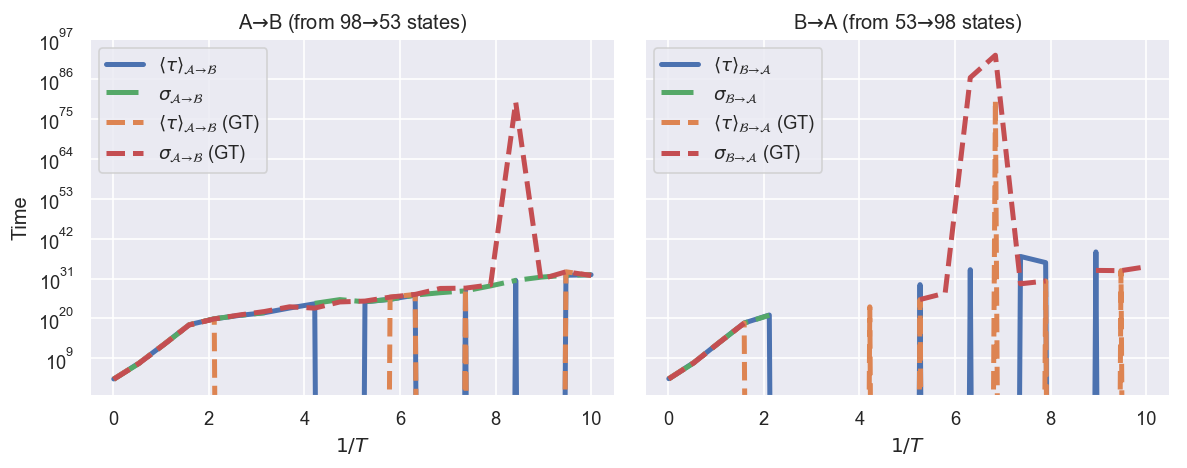

In [16]:
#eigendecomposition fails below T=1.0. GT calculation for MFPTAB is slow for this 1000-state network,
#so checked the low-T range using PATHSAMPLE (in visualization.py)
#this can be a SI figure if necessary
plot_AB_fpt_moments_vs_temperature(betas=np.linspace(0.01, 10., 20))

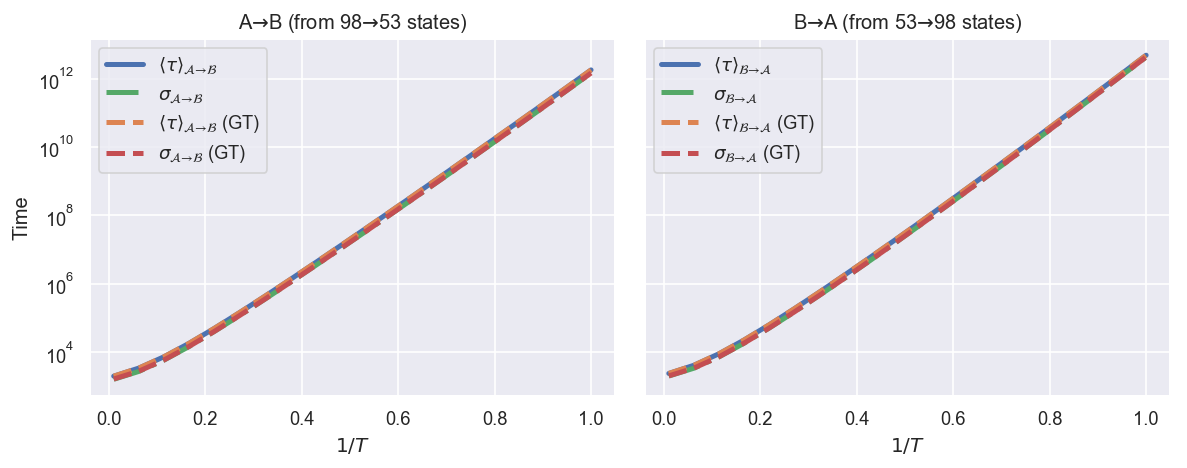

In [17]:
plot_AB_fpt_moments_vs_temperature(betas=np.linspace(0.01, 1., 20), rm_type='hybrid', percent_retained=5)

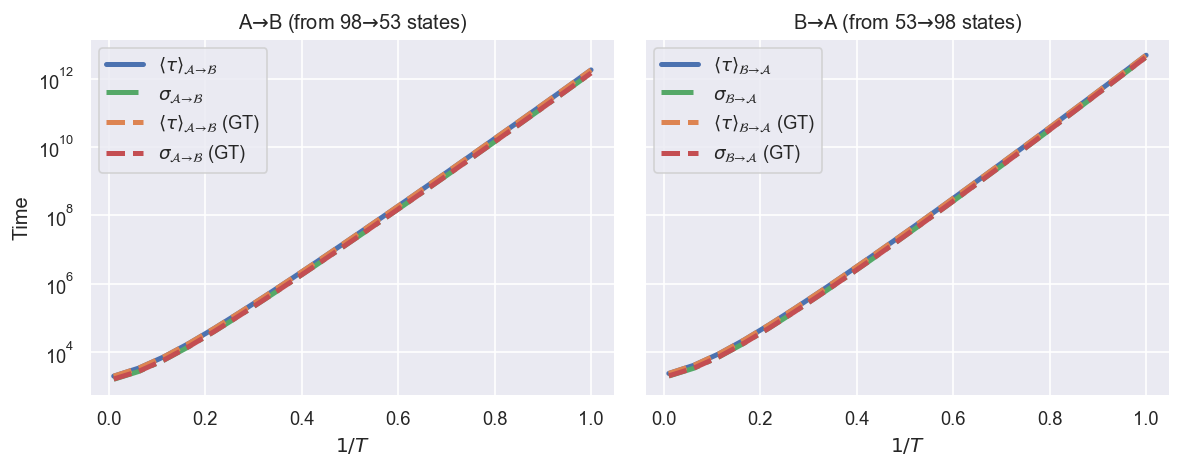

In [19]:
plot_AB_fpt_moments_vs_temperature(betas=np.linspace(0.01, 1., 20), rm_type='combined', percent_retained=10)

## Partial GT for Basin Escape

In [16]:
import lib.partialGT as pgt
def prune_basins(beta, percent_retained_in_B, rm_type, 
                 data_path=Path('KTN_data/9state'), dopdf=True):
    """ Prune each basin and plot the full PT vs reduced PT."""
    B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=data_path,beta=beta,Emax=None,Nmax=None,screen=False)
    communities = pgt.read_communities(data_path/'communities_bace9.dat', index_sel)
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    for j in communities:
        beta, tau, gttau, pt, gtpt = pgt.prune_source(beta, BS=communities[j], 
                                                      percent_retained_in_B=percent_retained_in_B,
                                                      rm_type=rm_type, data_path=data_path, dopdf=dopdf)
        ax = axes[int(j/3)][j%3]
        ax.set_title(f"Escape from {j}, T={(1.0/beta):.2f}")
        names=["AUI","B"]
        ax.plot(pt[0]/tau[0],pt[1],'C0-',lw=2,label=r"Full $P(\tau)$")
        ax.plot(gtpt[0]/tau[0],gtpt[1],'C1-.',lw=2,label=r"$P^{GT}(\tau)$")
        ax.legend()
        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.set_xlim(0.000001,1000.)
        if j==7:
            ax.set_xlabel(r"$t/\langle t \rangle$")
        if j%3 == 0:
            ax.set_ylabel(r"$\langle t \rangle p(t/\langle t \rangle)$")
        #ax.set_ylim(pt[1].min()/10.0,100.0)
    fig.tight_layout()
        

## T=10

Nodes to eliminate: 0.8924731182795699, percent retained: 10.75268817204301
Nodes to eliminate: 0.8823529411764706, percent retained: 11.764705882352942
Nodes to eliminate: 0.8909090909090909, percent retained: 10.909090909090908
Nodes to eliminate: 0.8876404494382022, percent retained: 11.235955056179776
Nodes to eliminate: 0.891156462585034, percent retained: 10.884353741496598
Nodes to eliminate: 0.8923076923076924, percent retained: 10.76923076923077
Nodes to eliminate: 0.8928571428571429, percent retained: 10.714285714285714
Nodes to eliminate: 0.8979591836734694, percent retained: 10.204081632653061
Nodes to eliminate: 0.918918918918919, percent retained: 8.108108108108109


/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)
/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


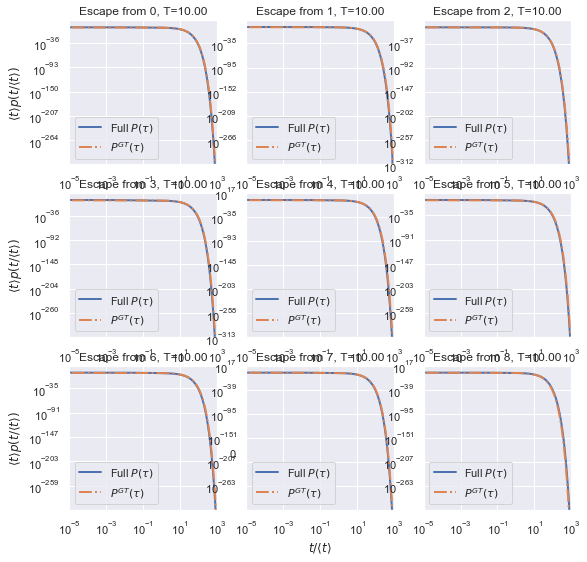

In [14]:
prune_basins(beta=1.0/10, percent_retained_in_B=5, rm_type='hybrid')

Nodes to eliminate: 0.8978494623655914, percent retained: 10.21505376344086
Nodes to eliminate: 0.8941176470588236, percent retained: 10.588235294117647
Nodes to eliminate: 0.9, percent retained: 10.0
Nodes to eliminate: 0.898876404494382, percent retained: 10.112359550561798
Nodes to eliminate: 0.8979591836734694, percent retained: 10.204081632653061
Nodes to eliminate: 0.9, percent retained: 10.0
Nodes to eliminate: 0.8928571428571429, percent retained: 10.714285714285714
Nodes to eliminate: 0.8979591836734694, percent retained: 10.204081632653061
Nodes to eliminate: 0.8918918918918919, percent retained: 10.81081081081081


/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)


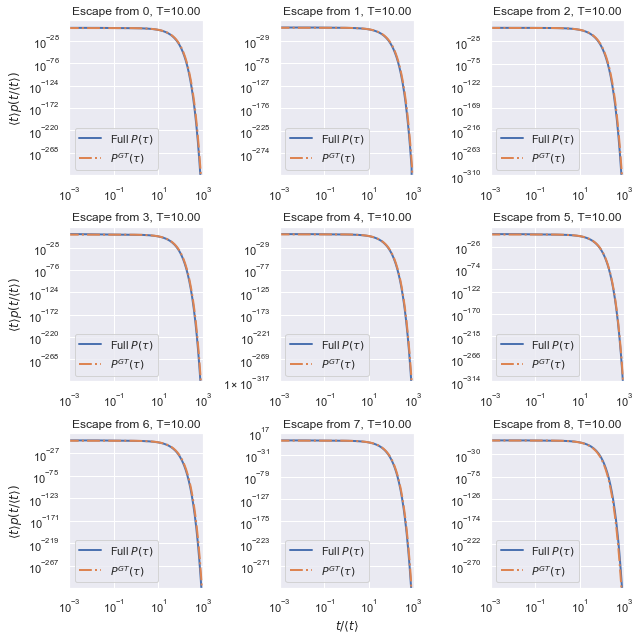

In [8]:
prune_basins(beta=1.0/10, percent_retained_in_B=10, rm_type='free_energy')

Nodes to eliminate: 0.8978494623655914, percent retained: 10.21505376344086
Nodes to eliminate: 0.8941176470588236, percent retained: 10.588235294117647
Nodes to eliminate: 0.9, percent retained: 10.0
Nodes to eliminate: 0.898876404494382, percent retained: 10.112359550561798
Nodes to eliminate: 0.8979591836734694, percent retained: 10.204081632653061
Nodes to eliminate: 0.9, percent retained: 10.0
Nodes to eliminate: 0.8928571428571429, percent retained: 10.714285714285714
Nodes to eliminate: 0.8979591836734694, percent retained: 10.204081632653061
Nodes to eliminate: 0.8918918918918919, percent retained: 10.81081081081081


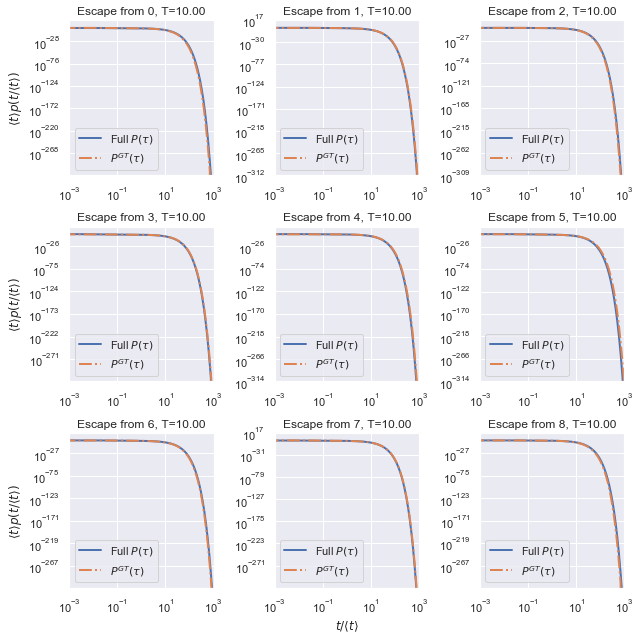

In [7]:
prune_basins(beta=1.0/10, percent_retained_in_B=10, rm_type='escape_time')

## T=1.0

Nodes to eliminate: 0.8924731182795699, percent retained: 10.75268817204301
Nodes to eliminate: 0.8823529411764706, percent retained: 11.764705882352942
Nodes to eliminate: 0.9, percent retained: 10.0
Nodes to eliminate: 0.8876404494382022, percent retained: 11.235955056179776
Nodes to eliminate: 0.8979591836734694, percent retained: 10.204081632653061
Nodes to eliminate: 0.8923076923076924, percent retained: 10.76923076923077
Nodes to eliminate: 0.8928571428571429, percent retained: 10.714285714285714
Nodes to eliminate: 0.8979591836734694, percent retained: 10.204081632653061
Nodes to eliminate: 0.918918918918919, percent retained: 8.108108108108109


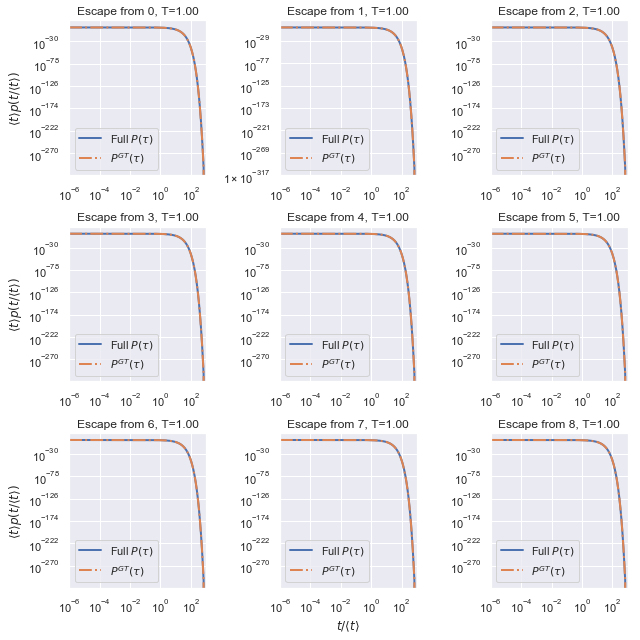

In [17]:
prune_basins(beta=1.0, percent_retained_in_B=5, rm_type='hybrid')

Nodes to eliminate: 0.8978494623655914, percent retained: 10.21505376344086
Nodes to eliminate: 0.8941176470588236, percent retained: 10.588235294117647
Nodes to eliminate: 0.9, percent retained: 10.0
Nodes to eliminate: 0.898876404494382, percent retained: 10.112359550561798
Nodes to eliminate: 0.8979591836734694, percent retained: 10.204081632653061
Nodes to eliminate: 0.9, percent retained: 10.0
Nodes to eliminate: 0.8928571428571429, percent retained: 10.714285714285714
Nodes to eliminate: 0.8979591836734694, percent retained: 10.204081632653061
Nodes to eliminate: 0.8918918918918919, percent retained: 10.81081081081081


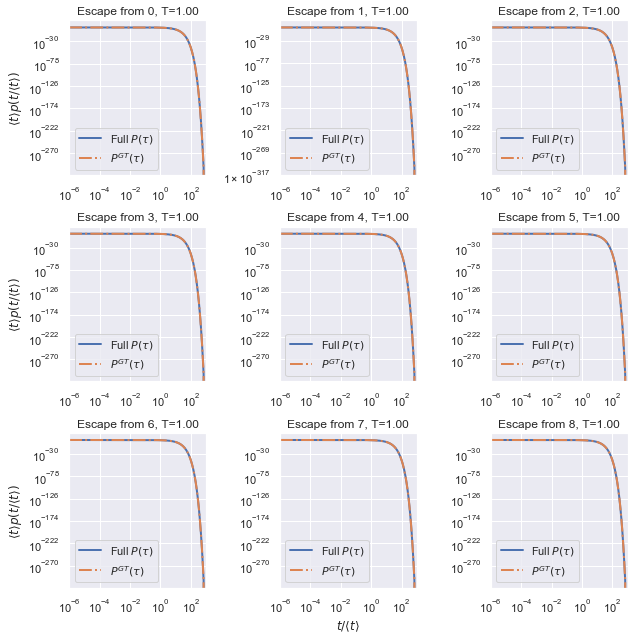

In [18]:
prune_basins(beta=1.0, percent_retained_in_B=10, rm_type='free_energy')

Nodes to eliminate: 0.8978494623655914, percent retained: 10.21505376344086
Nodes to eliminate: 0.8941176470588236, percent retained: 10.588235294117647
Nodes to eliminate: 0.9, percent retained: 10.0
Nodes to eliminate: 0.898876404494382, percent retained: 10.112359550561798
Nodes to eliminate: 0.8979591836734694, percent retained: 10.204081632653061
Nodes to eliminate: 0.9, percent retained: 10.0
Nodes to eliminate: 0.8928571428571429, percent retained: 10.714285714285714
Nodes to eliminate: 0.8979591836734694, percent retained: 10.204081632653061
Nodes to eliminate: 0.8918918918918919, percent retained: 10.81081081081081


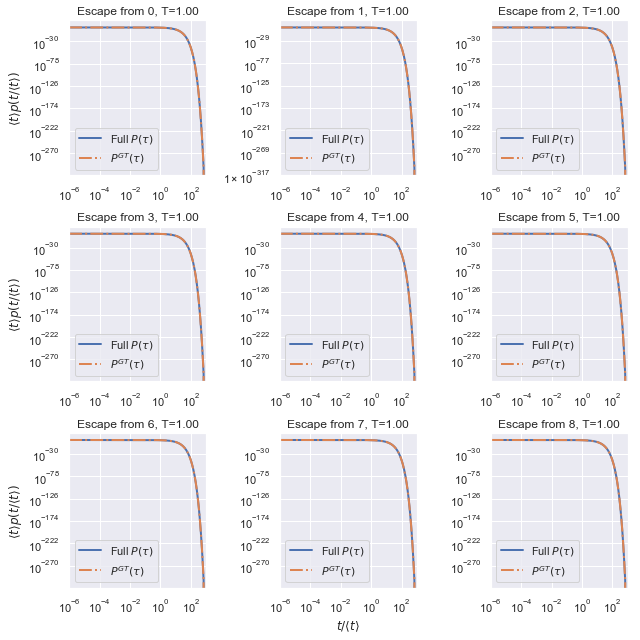

In [19]:
prune_basins(beta=1.0, percent_retained_in_B=10, rm_type='combined')

Nodes to eliminate: 0.8978494623655914, percent retained: 10.21505376344086
Nodes to eliminate: 0.8941176470588236, percent retained: 10.588235294117647
Nodes to eliminate: 0.9, percent retained: 10.0
Nodes to eliminate: 0.898876404494382, percent retained: 10.112359550561798
Nodes to eliminate: 0.8979591836734694, percent retained: 10.204081632653061
Nodes to eliminate: 0.9, percent retained: 10.0
Nodes to eliminate: 0.8928571428571429, percent retained: 10.714285714285714
Nodes to eliminate: 0.8979591836734694, percent retained: 10.204081632653061
Nodes to eliminate: 0.8918918918918919, percent retained: 10.81081081081081


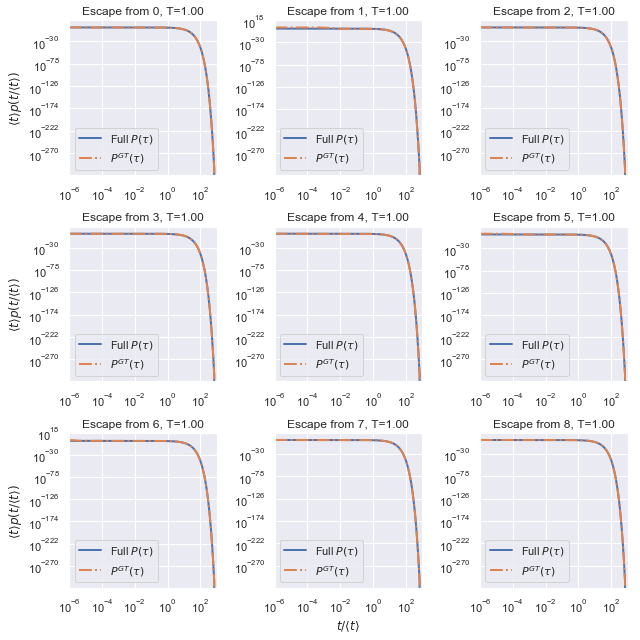

In [20]:
prune_basins(beta=1.0, percent_retained_in_B=10, rm_type='escape_time')

## Low temperature calculations

Nodes to eliminate: 0.8924731182795699, percent retained: 10.75268817204301
Nodes to eliminate: 0.8823529411764706, percent retained: 11.764705882352942
Nodes to eliminate: 0.9, percent retained: 10.0
Nodes to eliminate: 0.898876404494382, percent retained: 10.112359550561798
Nodes to eliminate: 0.9047619047619048, percent retained: 9.523809523809524
Nodes to eliminate: 0.8923076923076924, percent retained: 10.76923076923077
Nodes to eliminate: 0.8928571428571429, percent retained: 10.714285714285714
Nodes to eliminate: 0.8979591836734694, percent retained: 10.204081632653061
Nodes to eliminate: 0.918918918918919, percent retained: 8.108108108108109


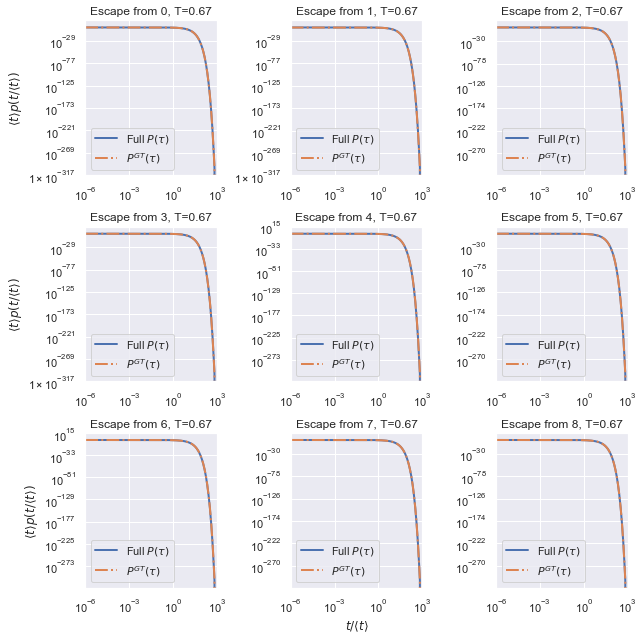

In [23]:
prune_basins(beta=1.5, percent_retained_in_B=5, rm_type='hybrid')

All 9 metastable macrostates exhibit single-exponential escape-time distributions. Unlike the A<->B FPT distributions, eigendecomposition can calculate the full escape-time distribution from all communities even at the low temperature of T=0.67. All partial GT schemes maintain the escape-time distributions (no discernable difference between the 4 methods).  

## Prune All Basins: GT all in one go

### T=1, conservatively REMOVING roughly 25% of the nodes

In [30]:
def compare_basins(beta, r_BF, r_Q, r_comms, data_path=Path('KTN_data/9state'), dopdf=True):
    """ Compare basin escape time distribution in network where all basins have been 
    pruned to the original network."""
    B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=data_path,beta=beta,Emax=None,Nmax=None,screen=False)
    communities = pgt.read_communities(data_path/'communities_bace9.dat', index_sel)
    D = np.ravel(K.sum(axis=0))
    escape_time = 1./D
    Q = diags(D)-K
    BF = beta*u-s
    BF -= BF.min()
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    for j in communities:
        tau, pt = pgt.compute_escape_stats(communities[j], BF, Q, dopdf=True)
        gttau, gtpt = pgt.compute_escape_stats(r_comms[j], r_BF, r_Q,
                                       tau_escape=tau[0], dopdf=True)
        ax = axes[int(j/3)][j%3]
        ax.set_title(f"Escape from {j}, T={(1.0/beta):.2f}")
        names=["AUI","B"]
        ax.plot(pt[0]/tau[0],pt[1],'C0-',lw=2,label=r"Full $P(\tau)$")
        ax.plot(gtpt[0]/tau[0],gtpt[1],'C1-.',lw=2,label=r"$P^{GT}(\tau)$")
        ax.legend()
        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.set_xlim(0.001,1000.)
        if j==7:
            ax.set_xlabel(r"$t/\langle t \rangle$")
        if j%3 == 0:
            ax.set_ylabel(r"$\langle t \rangle p(t/\langle t \rangle)$")
        #ax.set_ylim(pt[1].min()/10.0,100.0)
    fig.tight_layout()

In [36]:
from matplotlib.colors import LogNorm
#calculate ratio of MFPT in reduced network to full network for all pairs of communities
#same for the second moment
def get_first_second_moment_ratios_reduced_full(beta, r_BF, r_Q, r_comms, data_path=Path('KTN_data/9state'),
                                               log=False):
    #first compute c1<->c2 passage time distributions on full network
    B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=data_path,beta=beta,Emax=None,Nmax=None,screen=False)
    D = np.ravel(K.sum(axis=0))
    Q = diags(D)-K
    BF = beta*u-s
    BF -= BF.min()
    communities = pgt.read_communities(data_path/'communities.dat', index_sel)
    ncomms = len(communities)
    #i <- j <tau> and <tau^2> ratios for reduced/full
    mfpt_mat = np.ones((ncomms, ncomms))
    std_mat = np.ones((ncomms, ncomms))
    for c1 in communities:
        for c2 in communities:
            if c1 < c2:
                #update matrices
                tau_full = pgt.compute_passage_stats(communities[c1], communities[c2], BF, Q, dopdf=False)
                #now compute c1<->c2 passage time distributions on reduced network
                tau = pgt.compute_passage_stats(r_comms[c1], r_comms[c2], r_BF, 
                                                r_Q, dopdf=False)
                #c2 <- c1
                mfpt_mat[c2][c1] = tau[0]/tau_full[0]
                std_mat[c2][c1] = tau[1]/tau_full[1]
                #c1 <-c2
                mfpt_mat[c1][c2] = tau[2]/tau_full[2]
                std_mat[c1][c2] = tau[3]/tau_full[3]
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8,4))
    if log:
        sns.heatmap(mfpt_mat, center=1.0, annot=False, cmap='RdYlBu', square=True,
                    norm=LogNorm(mfpt_mat.min(), mfpt_mat.max()), 
                    cbar_kws={"ticks":[0,1,10,1e2,1e3]}, ax=ax0)
        sns.heatmap(std_mat, center=1.0, annot=False, cmap='RdYlBu', square=True,
                    norm=LogNorm(std_mat.min(), std_mat.max()), 
                    cbar_kws={"ticks":[0,1,10,1e2,1e3,1e4,1e5]}, ax=ax1)
    else:
        sns.heatmap(mfpt_mat, center=1.0, annot=True, robust=True, square=True, cmap='RdYlBu', ax=ax0)
        sns.heatmap(std_mat, center=1.0, annot=True, robust=True, square=True, cmap='RdYlBu', ax=ax1)
    ax0.set_title('MFPT GT/full')
    ax1.set_title(r'$\sigma$ GT/full')
    fig.tight_layout()
    return mfpt_mat, std_mat

Source comm: 6, Source nodes: 186
Percent eliminated from basin: 23.118279569892472
Source comm: 5, Source nodes: 85
Percent eliminated from basin: 29.41176470588235
Source comm: 4, Source nodes: 110
Percent eliminated from basin: 23.636363636363637
Source comm: 2, Source nodes: 89
Percent eliminated from basin: 20.224719101123597
Source comm: 3, Source nodes: 147
Percent eliminated from basin: 24.489795918367346
Source comm: 1, Source nodes: 130
Percent eliminated from basin: 20.0
Source comm: 0, Source nodes: 112
Percent eliminated from basin: 21.428571428571427
Source comm: 7, Source nodes: 98
Percent eliminated from basin: 23.46938775510204
Source comm: 8, Source nodes: 37
Percent eliminated from basin: 35.13513513513514
Removed 234 of 994 nodes, retained 76.45875251509054 percent


/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)
/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)


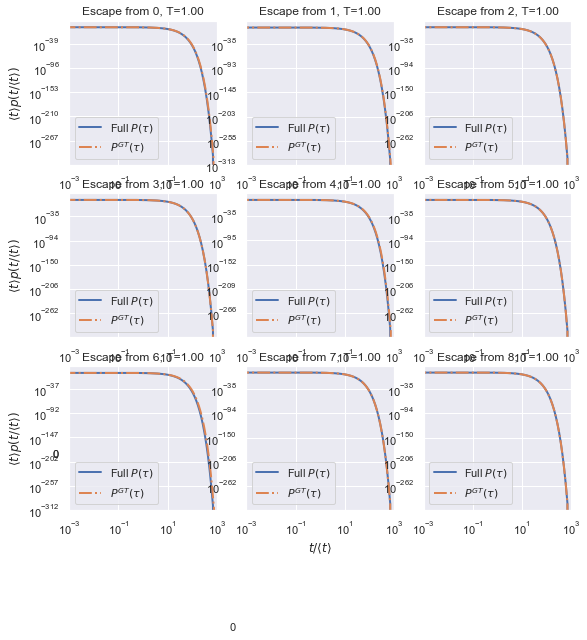

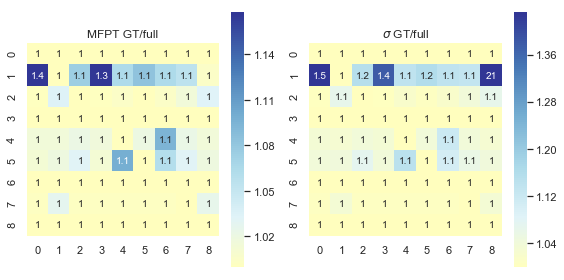

In [37]:
#start by conservatively removing 25% of the nodes at T=1
#recall, that these nodes do not have a high tpp density
r_B, r_D, r_Q, r_N, r_BF, r_communities, rm_reg = pgt.prune_all_basins(beta=1.0, data_path=Path('KTN_data/9state'),
                                                               rm_type='hybrid', percent_retained=53)
compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)

* Seems like passage times to basin 1 are a bit off, especially the variance of the 8 -> 1 fpt distribution
* community 1 is not A or B

In [38]:
r_B, r_D, r_Q, r_N, r_BF, r_communities, rm_reg = pgt.prune_all_basins(beta=1.0, data_path=Path('KTN_data/9state'),
                                                               rm_type='free_energy', percent_retained=75)

Source comm: 6, Source nodes: 186
Percent eliminated from basin: 25.268817204301076
Source comm: 5, Source nodes: 85
Percent eliminated from basin: 24.705882352941178
Source comm: 4, Source nodes: 110
Percent eliminated from basin: 25.454545454545453
Source comm: 2, Source nodes: 89
Percent eliminated from basin: 24.719101123595507
Source comm: 3, Source nodes: 147
Percent eliminated from basin: 25.170068027210885
Source comm: 1, Source nodes: 130
Percent eliminated from basin: 25.384615384615383
Source comm: 0, Source nodes: 112
Percent eliminated from basin: 25.0
Source comm: 7, Source nodes: 98
Percent eliminated from basin: 25.510204081632654
Source comm: 8, Source nodes: 37
Percent eliminated from basin: 24.324324324324323
Removed 250 of 994 nodes, retained 74.84909456740442 percent


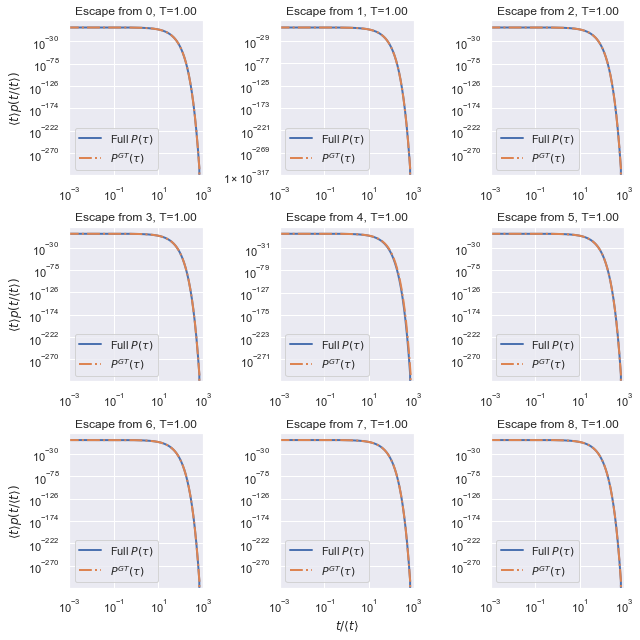

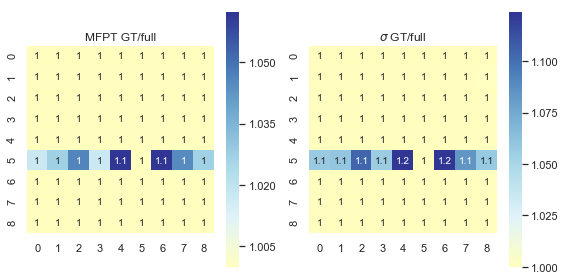

In [39]:
compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)

* Interestingly, removing nodes by free energy works even better than the hybrid heuristic. Max error of 1.2.
* In this case, passage stats to basin 5 are the most erroneous. Why is it that theres always one basin that suffers?

Source comm: 6, Source nodes: 186
Percent eliminated from basin: 25.268817204301076
Source comm: 5, Source nodes: 85
Percent eliminated from basin: 24.705882352941178
Source comm: 4, Source nodes: 110
Percent eliminated from basin: 25.454545454545453
Source comm: 2, Source nodes: 89
Percent eliminated from basin: 24.719101123595507
Source comm: 3, Source nodes: 147
Percent eliminated from basin: 25.170068027210885
Source comm: 1, Source nodes: 130
Percent eliminated from basin: 25.384615384615383
Source comm: 0, Source nodes: 112
Percent eliminated from basin: 25.0
Source comm: 7, Source nodes: 98
Percent eliminated from basin: 25.510204081632654
Source comm: 8, Source nodes: 37
Percent eliminated from basin: 24.324324324324323
Removed 250 of 994 nodes, retained 74.84909456740442 percent


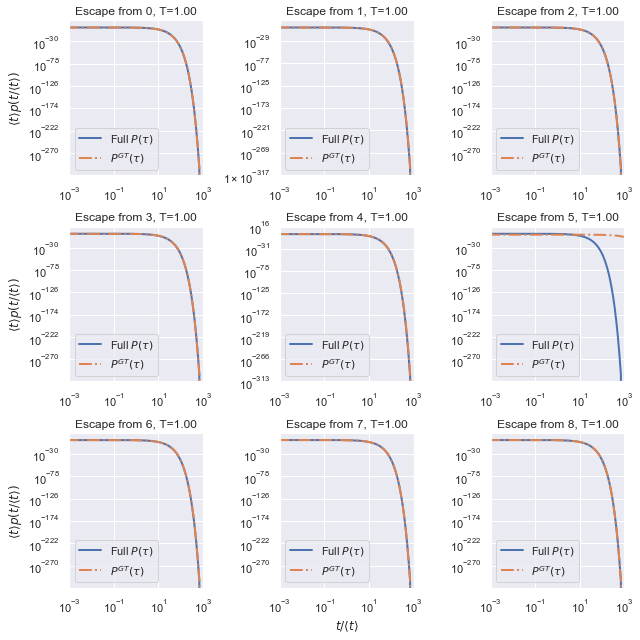

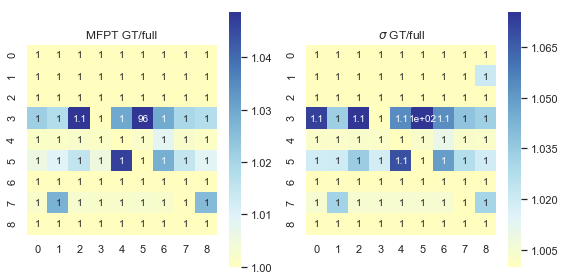

In [40]:
r_B, r_D, r_Q, r_N, r_BF, r_communities, rm_reg = pgt.prune_all_basins(beta=1.0, data_path=Path('KTN_data/9state'),
                                                               rm_type='escape_time', percent_retained=75)
compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)

* Extremely erroneous result for 3 <- 5 fpt moment, owing to the fact that the escape time distribution from community 5 was not preserved. This could be resolved my removing less states from community 5.
* But the result are extremely accurate (max error of 1.1)

Source comm: 6, Source nodes: 186
Percent eliminated from basin: 25.268817204301076
Source comm: 5, Source nodes: 85
Percent eliminated from basin: 24.705882352941178
Source comm: 4, Source nodes: 110
Percent eliminated from basin: 25.454545454545453
Source comm: 2, Source nodes: 89
Percent eliminated from basin: 24.719101123595507
Source comm: 3, Source nodes: 147
Percent eliminated from basin: 25.170068027210885
Source comm: 1, Source nodes: 130
Percent eliminated from basin: 25.384615384615383
Source comm: 0, Source nodes: 112
Percent eliminated from basin: 25.0
Source comm: 7, Source nodes: 98
Percent eliminated from basin: 25.510204081632654
Source comm: 8, Source nodes: 37
Percent eliminated from basin: 24.324324324324323
Removed 250 of 994 nodes, retained 74.84909456740442 percent


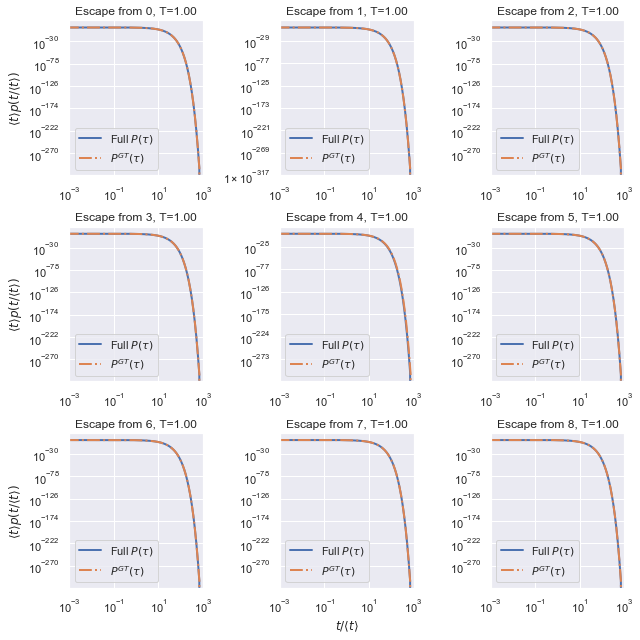

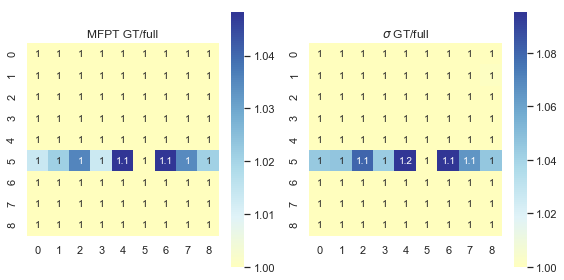

In [41]:
r_B, r_D, r_Q, r_N, r_BF, r_communities, rm_reg = pgt.prune_all_basins(beta=1.0, data_path=Path('KTN_data/9state'),
                                                               rm_type='combined', percent_retained=75)
compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)

* New, combined heuristic definitely wins on all fronts!

### T=1, this time RETAINING about 25%

In [43]:
r_B, r_D, r_Q, r_N, r_BF, r_communities, rm_reg = pgt.prune_all_basins(beta=1.0, data_path=Path('KTN_data/9state'),
                                                               rm_type='hybrid', percent_retained=13)

Source comm: 6, Source nodes: 186
Percent eliminated from basin: 74.19354838709677
Source comm: 5, Source nodes: 85
Percent eliminated from basin: 78.82352941176471
Source comm: 4, Source nodes: 110
Percent eliminated from basin: 78.18181818181819
Source comm: 2, Source nodes: 89
Percent eliminated from basin: 73.03370786516854
Source comm: 3, Source nodes: 147
Percent eliminated from basin: 77.55102040816327
Source comm: 1, Source nodes: 130
Percent eliminated from basin: 73.84615384615384
Source comm: 0, Source nodes: 112
Percent eliminated from basin: 75.0
Source comm: 7, Source nodes: 98
Percent eliminated from basin: 74.48979591836735
Source comm: 8, Source nodes: 37
Percent eliminated from basin: 81.08108108108108
Removed 753 of 994 nodes, retained 24.24547283702213 percent


/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)


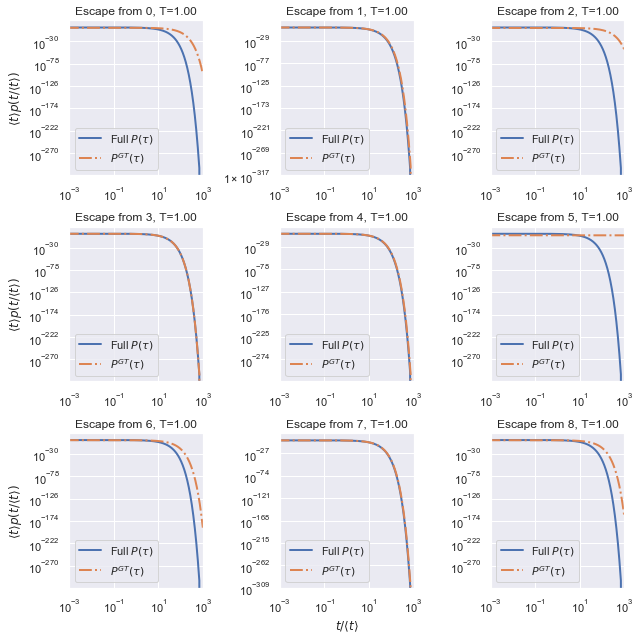

In [44]:
compare_basins(1.0, r_BF, r_Q, r_communities)

Now we start to see pretty significant errors in the escape time distributions from reduced basins 0, 2, 5, 6, and 8

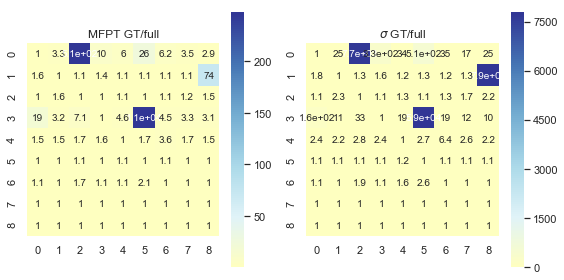

In [45]:
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities, log=False)

* A few very erroneous results (0<-2, 3<-5, 1<-8), others with ratios on the order of 10, but even MFPTs are not guaranteed to be within a factor of 10

In [47]:
r_B, r_D, r_Q, r_N, r_BF, r_communities, rm_reg = pgt.prune_all_basins(beta=1.0, data_path=Path('KTN_data/9state'),
                                                               rm_type='free_energy', percent_retained=25)

Source comm: 6, Source nodes: 186
Percent eliminated from basin: 74.73118279569893
Source comm: 5, Source nodes: 85
Percent eliminated from basin: 74.11764705882354
Source comm: 4, Source nodes: 110
Percent eliminated from basin: 74.54545454545455
Source comm: 2, Source nodes: 89
Percent eliminated from basin: 74.15730337078652
Source comm: 3, Source nodes: 147
Percent eliminated from basin: 74.82993197278911
Source comm: 1, Source nodes: 130
Percent eliminated from basin: 74.61538461538461
Source comm: 0, Source nodes: 112
Percent eliminated from basin: 75.0
Source comm: 7, Source nodes: 98
Percent eliminated from basin: 74.48979591836735
Source comm: 8, Source nodes: 37
Percent eliminated from basin: 72.97297297297297
Removed 741 of 994 nodes, retained 25.452716297786722 percent


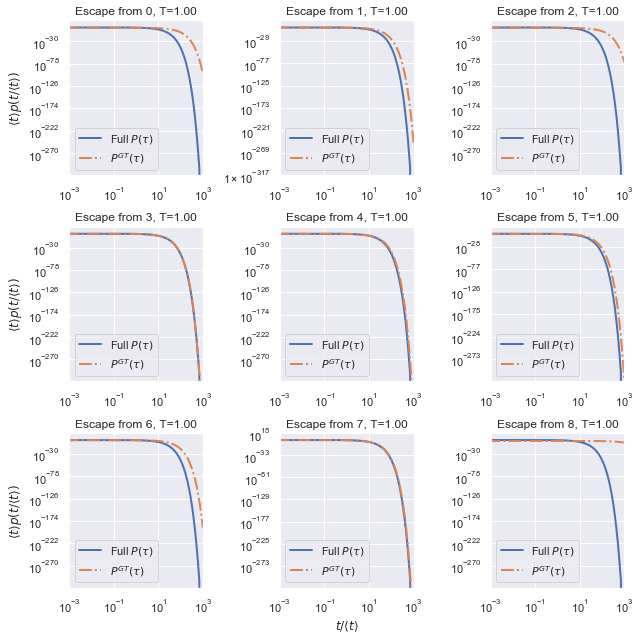

In [48]:
compare_basins(1.0, r_BF, r_Q, r_communities)

* If we use free energy to remove nodes instead of the hybrid approach, we also have errors, same communities as in `hybrid` approach + community 1

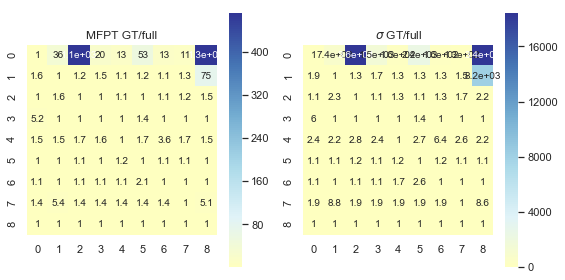

In [49]:
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)

* The anomolously erroneous community pairs (0 <- 2, 0<-8, 1<-8) are even more erroneous with the `free energy` method than with the `hybrid` method
* But here, the vast majority of ratios are within a factor of 10, unlike in the `hybrid` approach.

Source comm: 6, Source nodes: 186
Percent eliminated from basin: 74.73118279569893
Source comm: 5, Source nodes: 85
Percent eliminated from basin: 74.11764705882354
Source comm: 4, Source nodes: 110
Percent eliminated from basin: 74.54545454545455
Source comm: 2, Source nodes: 89
Percent eliminated from basin: 74.15730337078652
Source comm: 3, Source nodes: 147
Percent eliminated from basin: 74.82993197278911
Source comm: 1, Source nodes: 130
Percent eliminated from basin: 74.61538461538461
Source comm: 0, Source nodes: 112
Percent eliminated from basin: 75.0
Source comm: 7, Source nodes: 98
Percent eliminated from basin: 74.48979591836735
Source comm: 8, Source nodes: 37
Percent eliminated from basin: 72.97297297297297
Removed 741 of 994 nodes, retained 25.452716297786722 percent


/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)
/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)


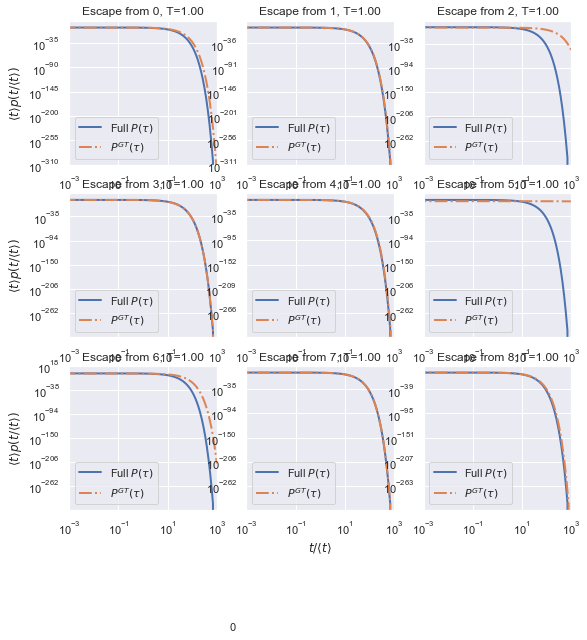

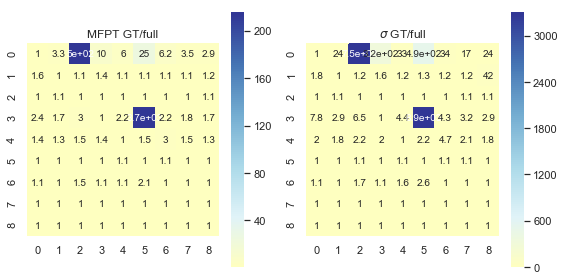

In [50]:
r_B, r_D, r_Q, r_N, r_BF, r_communities, rm_reg = pgt.prune_all_basins(beta=1.0, data_path=Path('KTN_data/9state'),
                                                               rm_type='escape_time', percent_retained=25)
compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)

* So the escape_time heuristic gets some of the escape time distributions wrong, same as `hybrid` and `free energy`.
* But it does well on the community <-> community passage time stats, with a few specific exceptions.
* Even for 2nd moment, most are within a factor of 10. In contrast, removing by 'free_energy' or by 'hybrid' approach leads to several orders of magnitude of error for passage time stats between many pairs of communities

Source comm: 6, Source nodes: 186
Percent eliminated from basin: 74.73118279569893
Source comm: 5, Source nodes: 85
Percent eliminated from basin: 74.11764705882354
Source comm: 4, Source nodes: 110
Percent eliminated from basin: 74.54545454545455
Source comm: 2, Source nodes: 89
Percent eliminated from basin: 74.15730337078652
Source comm: 3, Source nodes: 147
Percent eliminated from basin: 74.82993197278911
Source comm: 1, Source nodes: 130
Percent eliminated from basin: 74.61538461538461
Source comm: 0, Source nodes: 112
Percent eliminated from basin: 75.0
Source comm: 7, Source nodes: 98
Percent eliminated from basin: 74.48979591836735
Source comm: 8, Source nodes: 37
Percent eliminated from basin: 72.97297297297297
Removed 741 of 994 nodes, retained 25.452716297786722 percent


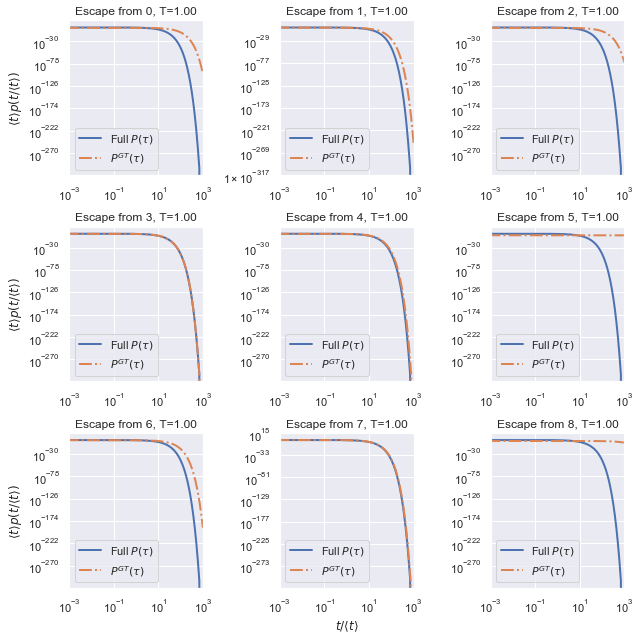

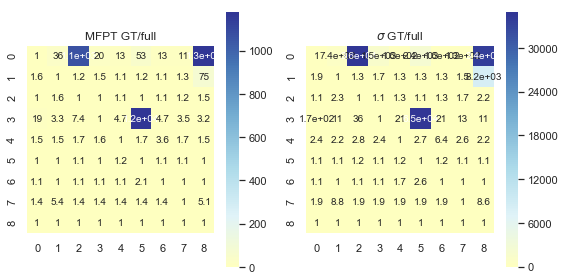

In [51]:
r_B, r_D, r_Q, r_N, r_BF, r_communities, rm_reg = pgt.prune_all_basins(beta=1.0, data_path=Path('KTN_data/9state'),
                                                               rm_type='combined', percent_retained=25)
compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)

### T=1, this time RETAINING about 50%

In [52]:
r_B, r_D, r_Q, r_N, r_BF, r_communities, rm_reg = pgt.prune_all_basins(beta=1.0, data_path=Path('KTN_data/9state'),
                                                               rm_type='hybrid', percent_retained=30)

Source comm: 6, Source nodes: 186
Percent eliminated from basin: 51.61290322580645
Source comm: 5, Source nodes: 85
Percent eliminated from basin: 54.11764705882353
Source comm: 4, Source nodes: 110
Percent eliminated from basin: 53.63636363636363
Source comm: 2, Source nodes: 89
Percent eliminated from basin: 46.06741573033708
Source comm: 3, Source nodes: 147
Percent eliminated from basin: 51.02040816326531
Source comm: 1, Source nodes: 130
Percent eliminated from basin: 49.23076923076923
Source comm: 0, Source nodes: 112
Percent eliminated from basin: 47.32142857142857
Source comm: 7, Source nodes: 98
Percent eliminated from basin: 50.0
Source comm: 8, Source nodes: 37
Percent eliminated from basin: 54.054054054054056
Removed 503 of 994 nodes, retained 49.396378269617706 percent


/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)
/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)


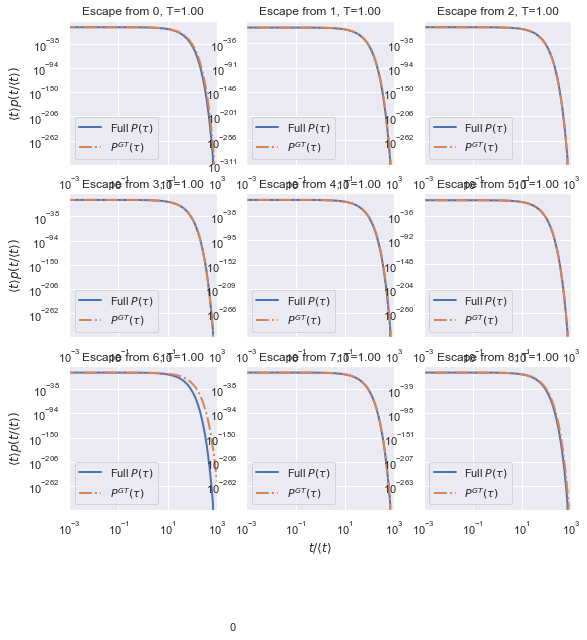

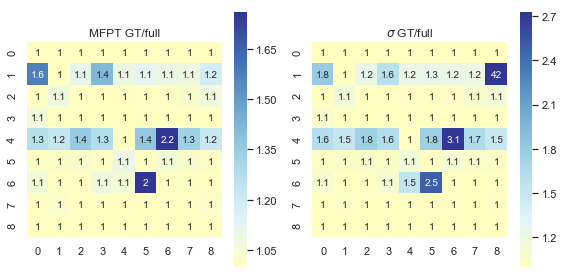

In [53]:
compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)

Removed 495 of 994 nodes, retained 50.201207243460765 percent


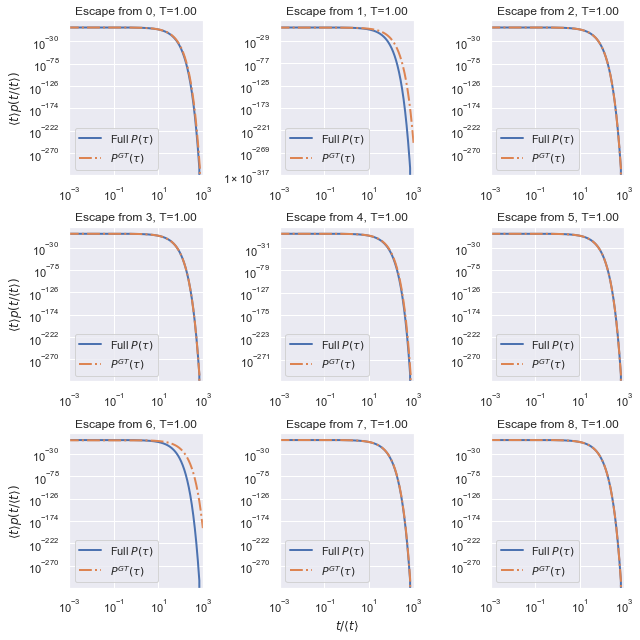

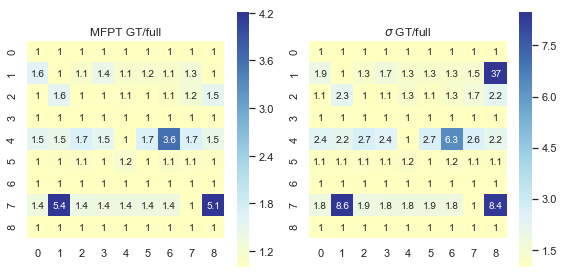

In [54]:
r_B, r_D, r_Q, r_N, r_BF, r_communities, rm_reg = pgt.prune_all_basins(beta=1.0, data_path=Path('KTN_data/9state'),
                                                        rm_type='free_energy', percent_retained=50, screen=False)
compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)

* When we keep 50%, the hybrid approach beats the free energy approach. Errors are smaller in passage stats between communities, and the escape-time distributions looks more accurate in reduced network

Removed 495 of 994 nodes, retained 50.201207243460765 percent


/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)
/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)


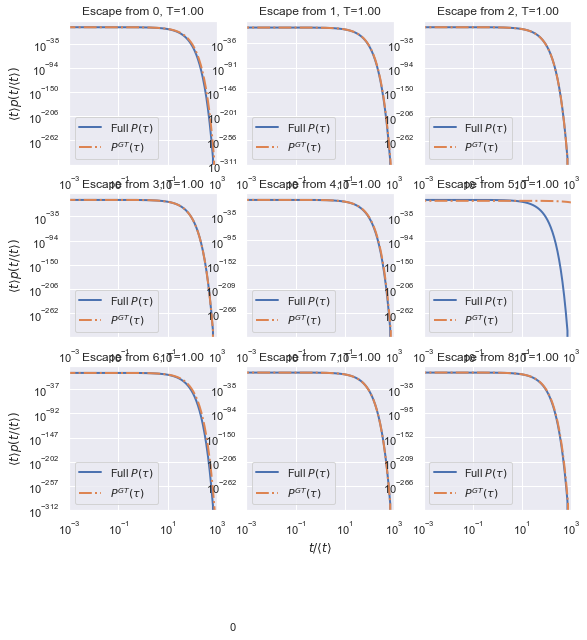

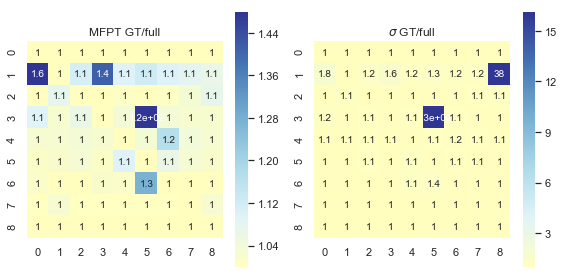

In [55]:
r_B, r_D, r_Q, r_N, r_BF, r_communities, rm_reg = pgt.prune_all_basins(beta=1.0, data_path=Path('KTN_data/9state'),
                                                        rm_type='escape_time', percent_retained=50, screen=False)
compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)

Removed 495 of 994 nodes, retained 50.201207243460765 percent


/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)
/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)


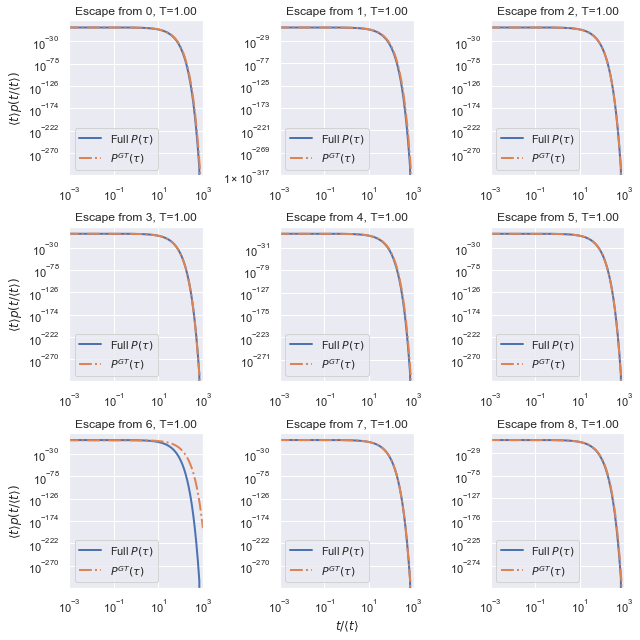

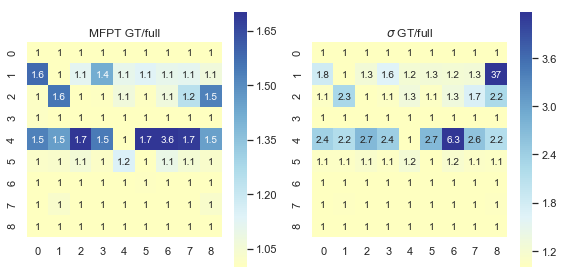

In [56]:
r_B, r_D, r_Q, r_N, r_BF, r_communities, rm_reg = pgt.prune_all_basins(beta=1.0, data_path=Path('KTN_data/9state'),
                                                        rm_type='combined', percent_retained=50, screen=False)
compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)

## Sequential GT: Recursively reduce the network

Reduce each basin and feed the reduced network into the next round of GT, until each basin only retains 25% of it's states, resulting in a reduced network that is 1/4 its original size.

### T=1, retaining 75%

In [10]:
import lib.partialGT as pgt

Removed 300 of 994 nodes,retained: 69.81891348088531


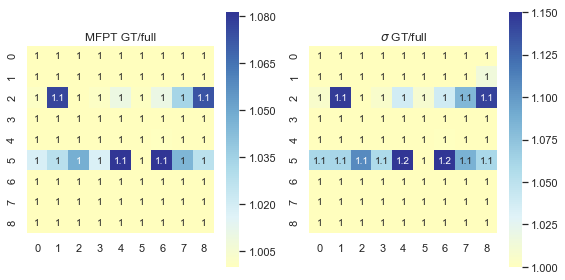

In [78]:
r_B, r_D, r_Q, r_N, r_BF, r_communities = pgt.prune_basins_sequentially(beta=1.0, data_path=Path('KTN_data/9state'),
                                                        rm_type='combined', percent_retained=70, screen=False)
#compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)

* the sequential approach does change the results for `combined` at all

Removed 297 of 994 nodes,retained: 70.12072434607646


/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)
/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


Removed 300 of 994 nodes, retained 69.81891348088531 percent


/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)


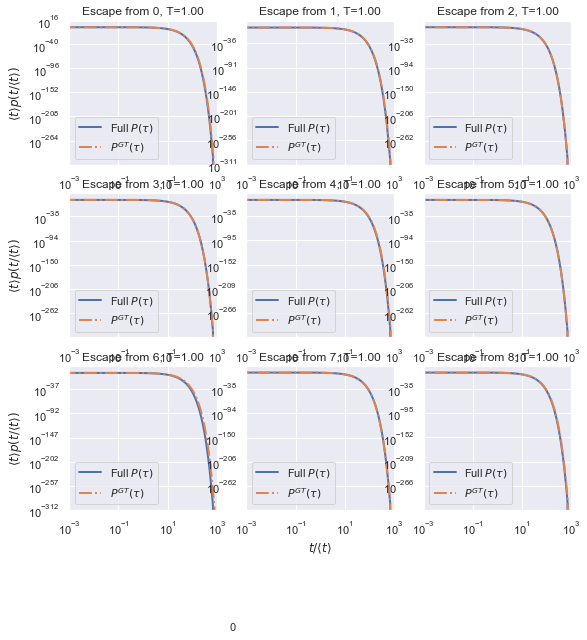

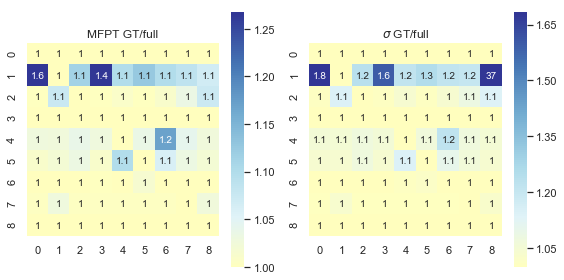

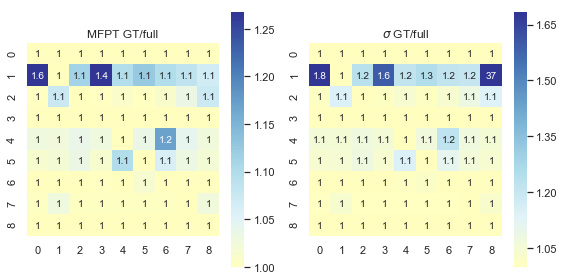

In [79]:
r_B, r_D, r_Q, r_N, r_BF, r_communities = pgt.prune_basins_sequentially(beta=1.0, data_path=Path('KTN_data/9state'),
                                                        rm_type='hybrid', percent_retained=47, screen=False)
compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)
r_B, r_D, r_Q, r_N, r_BF, r_communities, rm_reg = pgt.prune_all_basins(beta=1.0, data_path=Path('KTN_data/9state'),
                                                        rm_type='hybrid', percent_retained=47, screen=False)
#compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)

* pruning sequentially offers a slight improvement in accuracy for the `hybrid` approach

Removed 300 of 994 nodes,retained: 69.81891348088531
Removed 300 of 994 nodes, retained 69.81891348088531 percent


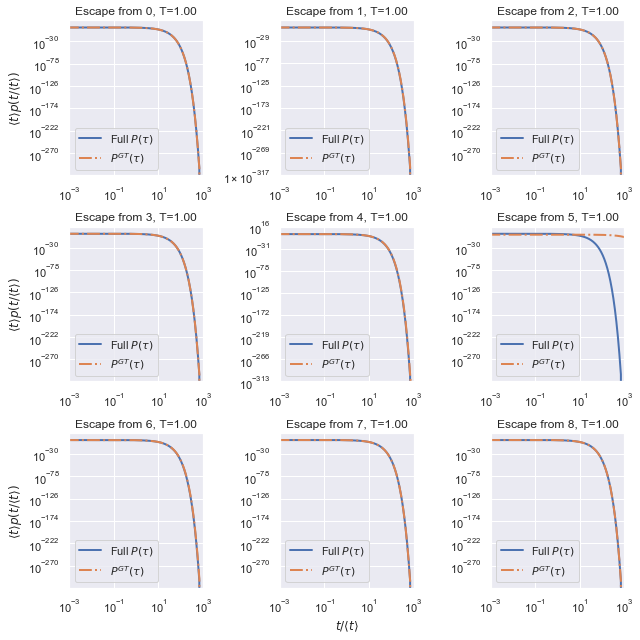

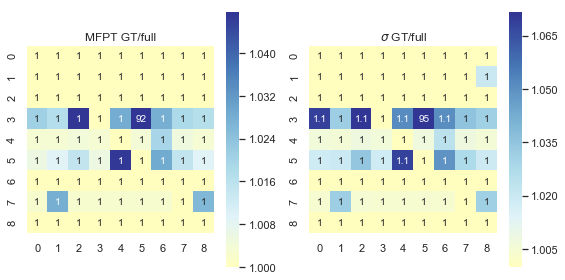

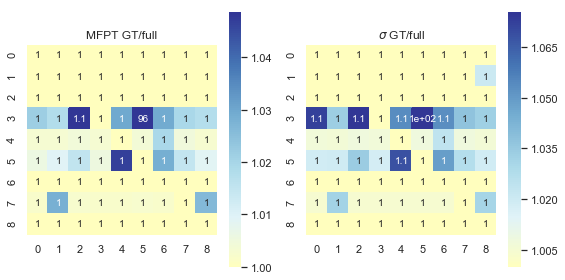

In [81]:
r_B, r_D, r_Q, r_N, r_BF, r_communities = pgt.prune_basins_sequentially(beta=1.0, data_path=Path('KTN_data/9state'),
                                                        rm_type='escape_time', percent_retained=70, screen=False)
compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)
r_B, r_D, r_Q, r_N, r_BF, r_communities, rm_reg = pgt.prune_all_basins(beta=1.0, data_path=Path('KTN_data/9state'),
                                                        rm_type='escape_time', percent_retained=70, screen=False)
#compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)

* The errors are amplified when pruning all basins vs. pruning sequentially, but again, the improvement is not too dramatic.

## T=1, retaining 25%

Removed 741 of 994 nodes,retained: 25.452716297786722
Removed 741 of 994 nodes, retained 25.452716297786722 percent


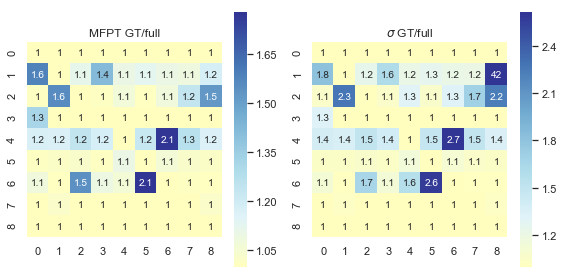

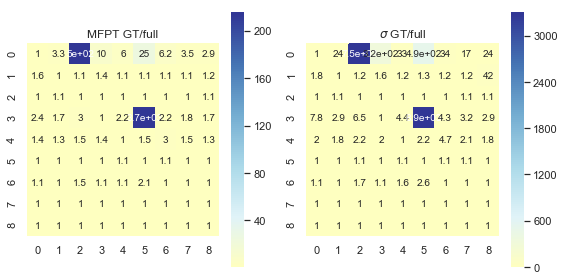

In [63]:
r_B, r_D, r_Q, r_N, r_BF, r_communities = pgt.prune_basins_sequentially(beta=1.0, data_path=Path('KTN_data/9state'),
                                                        rm_type='escape_time', percent_retained=25, screen=False)
#compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)
r_B, r_D, r_Q, r_N, r_BF, r_communities, rm_reg = pgt.prune_all_basins(beta=1.0, data_path=Path('KTN_data/9state'),
                                                        rm_type='escape_time', percent_retained=25, screen=False)
#compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)

* When we only retain 25%, we see a more dramatic improvement by employing the sequential approach.

Removed 741 of 994 nodes,retained: 25.452716297786722
Removed 741 of 994 nodes, retained 25.452716297786722 percent


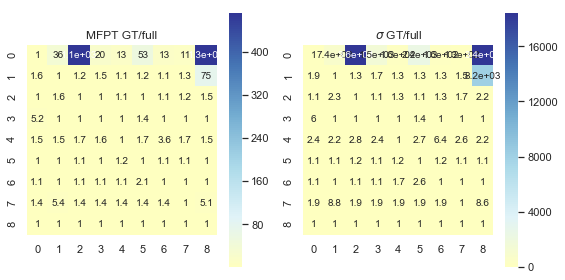

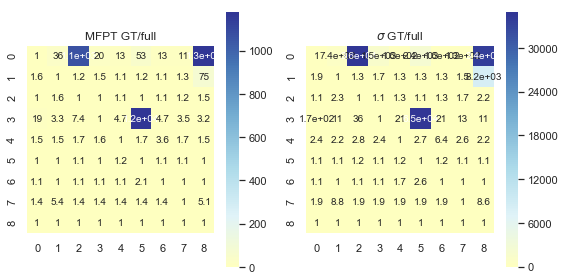

In [66]:
r_B, r_D, r_Q, r_N, r_BF, r_communities = pgt.prune_basins_sequentially(beta=1.0, data_path=Path('KTN_data/9state'),
                                                        rm_type='combined', percent_retained=25, screen=False)
#compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)
r_B, r_D, r_Q, r_N, r_BF, r_communities, rm_reg = pgt.prune_all_basins(beta=1.0, data_path=Path('KTN_data/9state'),
                                                        rm_type='combined', percent_retained=25, screen=False)
#compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)

Removed 747 of 994 nodes,retained: 24.849094567404425


/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)


Removed 753 of 994 nodes, retained 24.24547283702213 percent


/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)


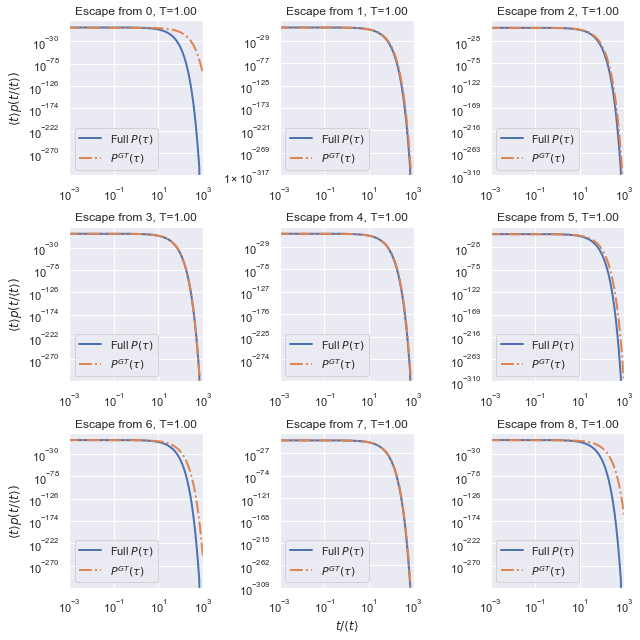

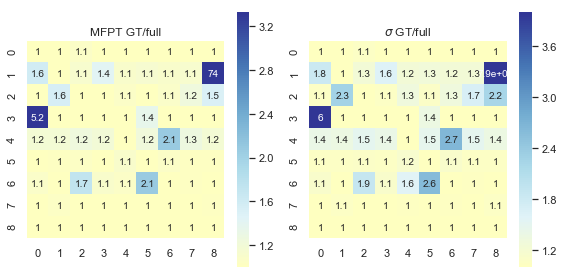

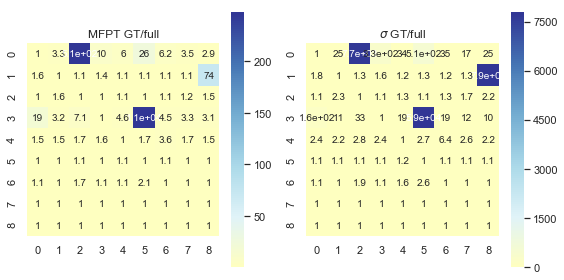

In [69]:
r_B, r_D, r_Q, r_N, r_BF, r_communities = pgt.prune_basins_sequentially(beta=1.0, data_path=Path('KTN_data/9state'),
                                                        rm_type='hybrid', percent_retained=13, screen=False)
compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)
r_B, r_D, r_Q, r_N, r_BF, r_communities, rm_reg = pgt.prune_all_basins(beta=1.0, data_path=Path('KTN_data/9state'),
                                                        rm_type='hybrid', percent_retained=13, screen=False)
#compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)

## T=1, retaining 10%

Removed 892 of 994 nodes,retained: 10.261569416498993
Removed 892 of 994 nodes, retained 10.261569416498993 percent


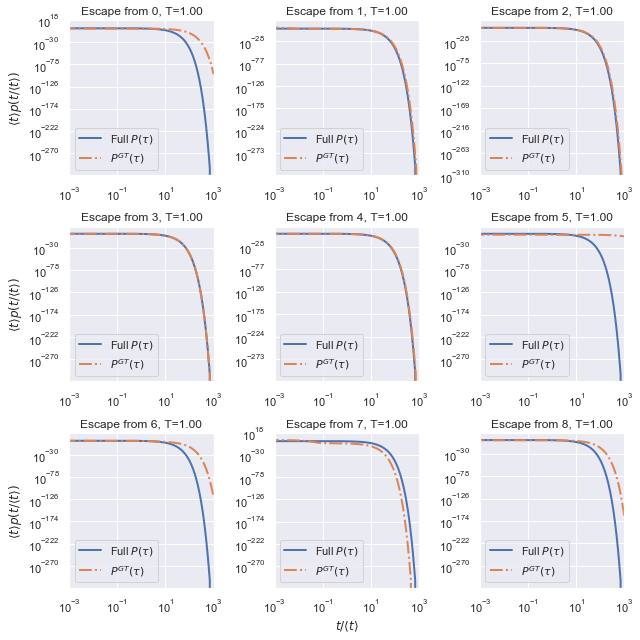

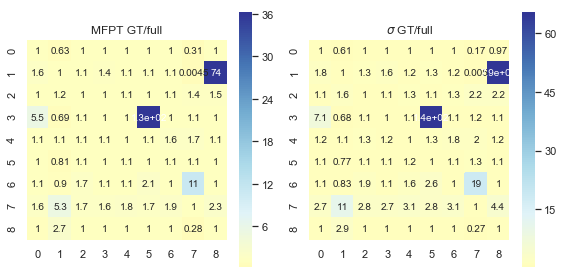

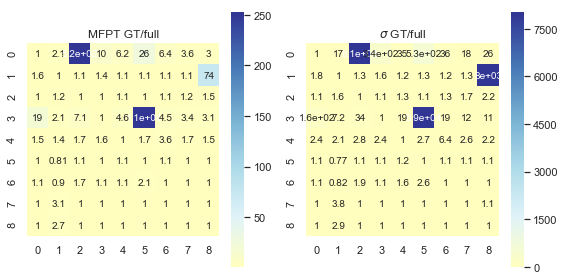

In [70]:
r_B, r_D, r_Q, r_N, r_BF, r_communities = pgt.prune_basins_sequentially(beta=1.0, data_path=Path('KTN_data/9state'),
                                                        rm_type='escape_time', percent_retained=10, screen=False)
compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)
r_B, r_D, r_Q, r_N, r_BF, r_communities, rm_reg = pgt.prune_all_basins(beta=1.0, data_path=Path('KTN_data/9state'),
                                                        rm_type='escape_time', percent_retained=10, screen=False)
#compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)

Removed 889 of 994 nodes,retained: 10.56338028169014
Removed 889 of 994 nodes, retained 10.56338028169014 percent


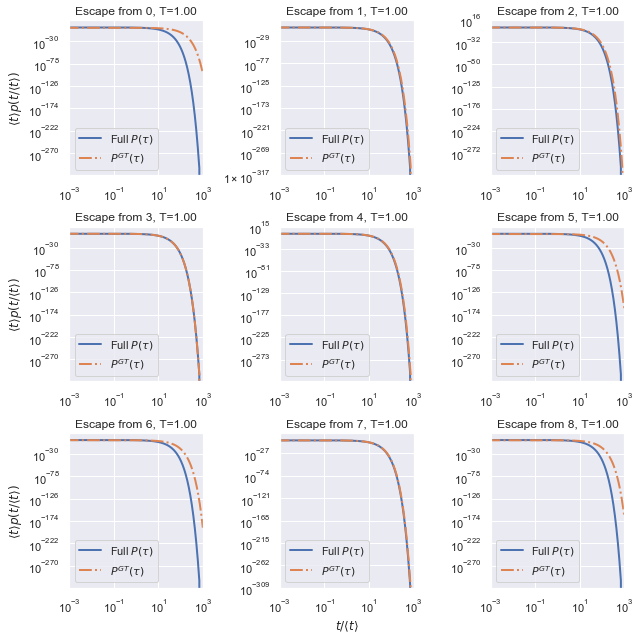

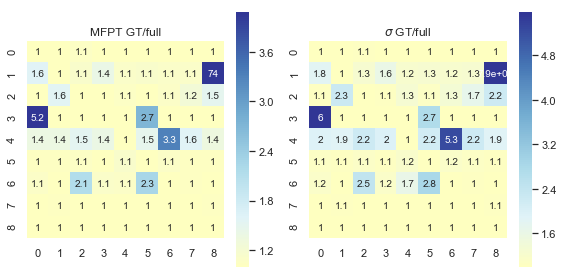

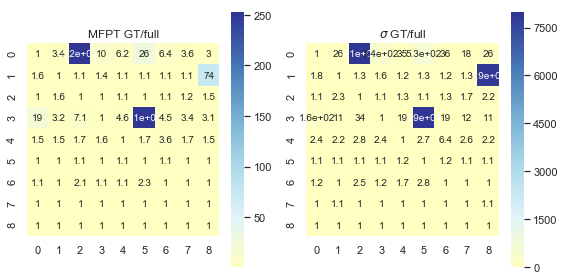

In [71]:
r_B, r_D, r_Q, r_N, r_BF, r_communities = pgt.prune_basins_sequentially(beta=1.0, data_path=Path('KTN_data/9state'),
                                                        rm_type='hybrid', percent_retained=5, screen=False)
compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)
r_B, r_D, r_Q, r_N, r_BF, r_communities, rm_reg = pgt.prune_all_basins(beta=1.0, data_path=Path('KTN_data/9state'),
                                                        rm_type='hybrid', percent_retained=5, screen=False)
#compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)

Removed 740 of 994 nodes,retained: 25.553319919517104


/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)
/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)


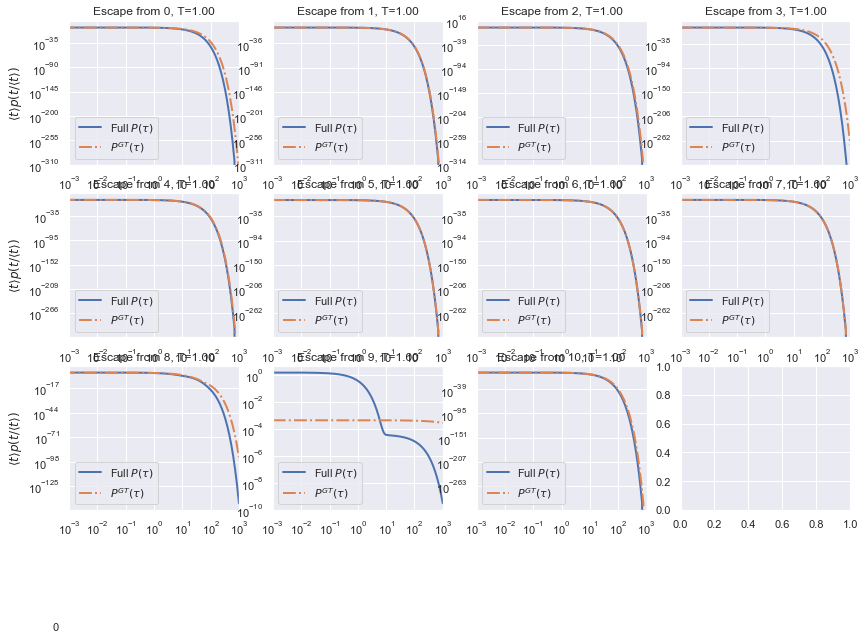

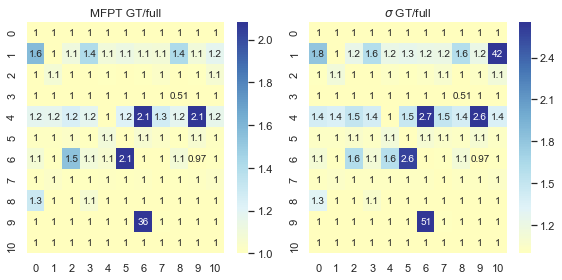

In [34]:
r_B, r_D, r_Q, r_N, r_BF, r_communities = pgt.prune_basins_sequentially(beta=1.0, data_path=Path('KTN_data/9state'),
                                                        rm_type='escape_time', percent_retained=25, screen=False)
#compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)
r_B, r_D, r_Q, r_N, r_BF, r_communities, rm_reg = pgt.prune_all_basins(beta=1.0, data_path=Path('KTN_data/9state'),
                                                        rm_type='escape_time', percent_retained=25, screen=False)
#compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)

Removed 250 of 994 nodes,retained: 74.84909456740442


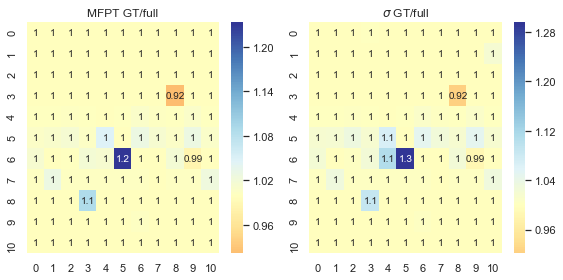

In [22]:
r_B, r_D, r_Q, r_N, r_BF, r_communities = pgt.prune_basins_sequentially(beta=1.0, data_path=Path('KTN_data/9state'),
                                                        rm_type='escape_time', percent_retained=75, screen=False)
#compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)

In [55]:
rQ = convert.K_from_Q(r_Q)
r_rho = np.exp(-r_BF)
r_rho /= r_rho.sum()
nu, vl, vr = spla.eig(rQ, left=True)
qsdo = np.abs(nu.real).argsort()
nu = nu.real[qsdo]
dp = np.sqrt(np.diagonal(vr.T.dot(vl))).real
vr_norm = vr.real.dot(np.diag(1.0/dp))
pi = vr_norm[:, qsdo[0]]
pi_alt = vr[:, qsdo[0]]
pi_alt.real.argsort()

array([443, 222, 226, 337, 283, 223, 155, 156, 258, 439, 333, 107, 486, 358, 463, 221, 318, 366, 480, 409, 444, 115,  76, 245,  94,  91, 350, 260, 193, 349,
       204, 383, 481, 335, 218, 407,   3, 401, 206, 321, 410, 195,  59, 423,  10, 471, 327,  15, 453,   9, 267, 473,  18, 479, 370, 266, 422, 415, 417, 477,
       213, 175, 434, 202, 448, 180,  19, 233, 314, 208, 211, 356, 215, 291, 325, 257,  37, 462, 313, 106, 311, 192,   1, 232, 322,   2, 288, 187,  99, 381,
       391, 319,  61, 296, 447, 162, 121,  74,  98, 157,  81, 389, 467, 201, 200, 194, 285, 237, 460, 235, 242, 396,  42, 259, 205,  73, 158,  75, 240,  12,
       144, 248, 303, 273, 164, 465, 343, 131, 178, 474, 365, 368,  84,  26,  41, 297, 275, 420, 488, 468, 432, 150, 372, 442, 300, 229, 238, 277, 234, 419,
       203, 450, 135, 317,  46,  57,  54, 197,  70, 251, 427, 138, 207, 183, 184, 332, 306,  32, 168, 397, 375,  50,  78, 456, 109, 102, 328, 376, 295, 342,
       160, 125, 264, 165, 152,  55, 310, 217,  97,  23, 1

In [57]:
pi /= pi.sum()
print(pi)

[4.62860672e-03 3.38690733e-12 4.53521949e-12 1.14126223e-14 1.77274865e-05 2.17980644e-05 4.10168108e-03 2.57987463e-02 1.23889285e-03 1.03504342e-13
 3.74373654e-14 1.99911495e-02 8.03761200e-11 3.96857132e-08 2.82382402e-04 6.68940702e-14 2.81471532e-04 2.24536311e-07 1.59416846e-13 9.37483865e-13
 2.78537660e-06 1.13745243e-07 5.36544081e-07 8.60006855e-09 3.69211694e-07 1.26929868e-02 2.41748019e-10 2.25520412e-06 1.98457778e-06 6.32215570e-06
 7.60615097e-06 8.04570427e-06 1.99424395e-09 5.41698047e-06 8.87667376e-03 2.87587345e-08 2.34925245e-06 2.10217846e-12 2.50633400e-04 1.54129739e-02
 1.85542017e-06 2.85242331e-10 4.60203332e-11 1.19676776e-06 5.55083984e-05 2.84671166e-02 1.02350972e-09 1.55985040e-04 3.82057451e-02 1.38190831e-05
 2.60416511e-09 6.53844933e-04 4.90206183e-03 2.80141749e-05 1.08084647e-09 6.89302809e-09 2.84954457e-04 1.04478174e-09 6.17517500e-06 3.46400781e-14
 3.27494882e-05 8.14119040e-12 4.05508904e-08 4.26733495e-04 9.04239797e-07 9.19805157e-08 2.1

In [3]:
sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

[(0.8941176470588235, 0.10196078431372557, 0.10980392156862737),
 (0.21568627450980393, 0.4941176470588236, 0.7215686274509804),
 (0.3019607843137256, 0.6862745098039216, 0.29019607843137263),
 (0.5960784313725492, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (0.9999999999999998, 1.0, 0.19999999999999996),
 (0.6509803921568629, 0.33725490196078434, 0.1568627450980391),
 (0.9686274509803922, 0.5058823529411766, 0.7490196078431374),
 (0.6, 0.6, 0.6)]

In [6]:
cols = sns.color_palette('Paired', 11)
cols[0]*2

(0.6509803921568628,
 0.807843137254902,
 0.8901960784313725,
 0.6509803921568628,
 0.807843137254902,
 0.8901960784313725)